In [1]:
import alpaca_trade_api as tradeapi
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from ta.trend import macd, macd_signal
import time
from ipywidgets import *
import PyQt5

In [2]:
APCA_API_BASE_URL = "https://paper-api.alpaca.markets"
APCA_API_KEY_ID = "PKG8YJEN7J4G065QVA9K"
APCA_API_SECRET_KEY = "VzWRlCAtrvEGsQGKJGtWRXEswk442vpR4fJJeLIw"
api = tradeapi.REST(base_url=APCA_API_BASE_URL, key_id=APCA_API_KEY_ID, secret_key=APCA_API_SECRET_KEY)
account = api.get_account()
account.status

'ACTIVE'

In [3]:
stocks = ['VLDR', 'WMT', 'BA', 'AAPL', 'TDOC', 'NIO', 'FB', 'MSFT', 'BABA', 'AMD', 'V', 'JPM', 'TSLA', 'BAC', 'CCL',
         'NVDA', 'DOCU', 'CRM', 'PYPL', 'U', 'PLUG', 'ZM', 'GOOG', 'AMZN', 'UAL', 'OXY', 'ARKQ']  

In [4]:
def process_stock_df(df):
    df.reset_index(inplace=True)
    df.columns = df.columns.droplevel()
    df.columns = ['Time'] + list(df.columns[1:])
    
def convert_time_to_num_minute(timestamp):
    return int(''.join(str(timestamp).split()[1].split(':')[:3])[:6])
    
def SMA(df, cnts = 20, add_col = True):
    if df.shape[0] < cnts: raise "Not enought data to calculate moving averages!"
    data = df['close'].rolling(window=cnts).mean()
    if add_col:
        df['SMA'+str(cnts)] = data
    return data

def Bollinger_Band(df, cnts = 20, add_col = True):
    if df.shape[0] < cnts: raise "Not enought data to calculate moving averages!"
    bbMid = SMA(df, cnts)
    std = df['close'].rolling(window=cnts).std()
    bbHigh = bbMid + std*2
    bbLow = bbMid - std*2
    if add_col:
        df['bbHigh'], df['bbMid'], df['bbLow'] = bbHigh, bbMid, bbLow
    return bbHigh, bbMid, bbLow

def MACD(df, sp1=55, sp2=89, sp3=40, add_col = True):
    data = df['close']
    exp1 = data.ewm(span=sp1, adjust=False).mean()
    exp2 = data.ewm(span=sp2, adjust=False).mean()
    macd = exp1-exp2
    exp3 = macd.ewm(span=sp3, adjust=False).mean()   
    if add_col:
        df['MACD_fast'] = macd
        df['MACD_slow'] = exp3
        df['MACD_diff'] = macd-exp3
    return macd, exp3, macd-exp3

def MACD_TA(df, sp1=12, sp2=26, sp3=9, add_col = True):
    macd_fast = macd(df['close'])
    macd_slow = macd_signal(df['close'])
    macd_diff = macd_fast - macd_slow
    if add_col:
        df['MACD_fast'] = macd_fast
        df['MACD_slow'] = macd_slow
        df['MACD_diff'] = macd_diff
    return macd_fast, macd_slow, macd_diff

def VWAP(df, add_col = True):
    l = df.index[0]
    res = pd.Series()
    for i in range(1, df.index[-1]+2):
        if i == df.index[-1] + 1 or str(tsla.iloc[i]['Time']).split()[0] != str(tsla.iloc[i-1]['Time']).split()[0]:
            data = df.iloc[l:i]
            vol = data['volume']
            pri = data['close']
            vwp = (vol * pri).cumsum() / vol.cumsum()
            res = pd.concat([res, vwp])
            l = i
    if add_col:
        df['vwap'] = res
    return res

def price_volume_ratio(df, avg_window = 3, add_col = True):
    pvr = abs(df['close'] - df['open']) / df['volume'] / df['close'] * 10e4
#     pvr = pvr.ewm(span=avg_window, adjust=False).mean()
    pvr = pvr.rolling(window=avg_window).mean()
    if add_col:
        df['pvr'] = pvr
    return pvr

In [5]:
def buyin_strategy_combined_v1(df, i, change_rate = -0.003, lag_buy = 5, diff_threshold_buy = 0.3, macd_boundry_buy = -5, 
                            sma20_gradient_macd = 0.001, sma20_gradient_bb = -0.001, sma5_gradient_bb = 0.001):
    main_factor_macd = 1 if df.iloc[i-lag_buy]['MACD_diff'] < 0 and df.iloc[i]['MACD_diff'] > 0 else 0
    main_factor_bb = 1 if any([df.loc[i, fom] < df.loc[i, 'bbLow'] for fom in ['close', 'low', 'high', 'open']]) else 0

    sub_factors_macd = []
    sub_factors_bb = []
    sub_factors_macd.append(df.iloc[i]['MACD_fast'] > macd_boundry_buy)
    sub_factors_macd.append(abs(sum(df.iloc[i-lag_buy : i]['MACD_diff'])/lag_buy) > diff_threshold_buy)
    sub_factors_macd.append((df.iloc[i]['SMA20'] - df.iloc[i-lag_buy]['SMA20']) / df.iloc[i]['SMA20'] > sma20_gradient_macd)

    sub_factors_bb.append((df.iloc[i]['SMA20'] - df.iloc[i-lag_buy]['SMA20']) / df.iloc[i]['SMA20'] > sma20_gradient_bb)
    sub_factors_bb.append((df.iloc[i]['SMA5'] - df.iloc[i-min(2, lag_buy)]['SMA5']) / df.iloc[i]['SMA5'] > sma5_gradient_bb)
    sub_factors_bb.append((df.loc[i, 'close'] - df.loc[i-1, 'close']) / df.loc[i, 'close'] > change_rate)

    return  0.35 * main_factor_macd * sum(sub_factors_macd)/len(sub_factors_macd) +  0.65 * main_factor_bb * sum(sub_factors_bb)/ len(sub_factors_bb)

def sell_strategy_combined_v1(df, i, last_buyin, lag_sell = 2, stoploss_rate = 0.025, diff_threshold_sell = 0.0005, macd_boundry_sell = 0):
            if df.iloc[i]['close'] < last_buyin*(1 - stoploss_rate): return 1000
            sell_factors = [tsla.iloc[i-lag_sell]['MACD_diff'] < 0, 
                            (df.loc[i-1, 'SMA5'] >= df.loc[i-1, 'SMA20'] and df.loc[i, 'SMA5'] < df.loc[i, 'SMA20']) , 
                            (df.loc[i-1, 'close'] > df.loc[i, 'bbHigh'] and df.loc[i, 'close'] < df.loc[i, 'bbHigh']),
                           (df.loc[i-1, 'close'] > df.loc[i, 'bbHigh'] and df.loc[i, 'close'] < df.loc[i, 'bbHigh'])]
            return sum(sell_factors)/len(sell_factors)

In [6]:
def normalize_macd(macd_diff, stock_price): 
    pwr_coeff = np.log(25)/ np.log(30) #基于最离谱的亚马逊股价计算，发现其比较合理的shrink值为比线性值稍低，这里取25/30，日后可调
    return macd_diff * 1 / np.power(stock_price/100, pwr_coeff)

def linreg(A, B):
    A = np.array(A).reshape((-1, 1))
    B = np.array(B)
    lr_model = LinearRegression().fit(A,B)
    return lr_model.coef_[0], lr_model.intercept_

def is_macd_trend_opposite_from_stock_value(df, i, span = 10):
    stock_val = df.loc[i-span : i, 'SMA5']
    macd = df.loc[i-span : i, 'MACD_fast']
    return linreg(range(len(stock_val)), stock_val)[0] * linreg(range(len(macd)), macd)[0] < 0

def buyin_strategy_combined_v2(df, i, lag_buy = 5, 
                            diff_threshold_buy = 0.08, macd_boundry_buy = -5, sma20_gradient_macd = -0.005, 
                            sma20_gradient_bb = -0.008, sma5_gradient_bb = -0.002, close_gradient_bb = 0.005,
                            macd_weight = 0.45, bb_weight = 0.55):
    main_factor_macd = 1 if df.iloc[i-lag_buy]['MACD_diff'] < 0 and df.iloc[i]['MACD_diff'] > 0 else 0
    main_factor_bb = 1 if any([df.loc[j, 'close'] < df.loc[j, 'bbLow'] for j in range(i-lag_buy, i+1)]) else 0

    sub_factors_macd = []
    sub_factors_bb = []
    
    sub_factors_macd.append(is_macd_trend_opposite_from_stock_value(df, i, span = 10))
    sub_factors_macd.append(df.iloc[i]['bbHigh'] > df.iloc[i]['close'])
    sub_factors_macd.append(normalize_macd(df.iloc[i]['MACD_diff'], df.iloc[i]['close']) > diff_threshold_buy)
    sub_factors_macd.append(normalize_macd(df.iloc[i]['MACD_diff'], df.iloc[i]['close']) > diff_threshold_buy and \
                           normalize_macd(df.iloc[i-1]['MACD_diff'], df.iloc[i-1]['close']) < diff_threshold_buy)
    sub_factors_macd.append(linreg(np.arange(10), df.iloc[i-10:i]['SMA20'])[0]  > sma20_gradient_macd)
    
    sub_factors_bb.append(linreg(np.arange(10), df.iloc[i-10:i]['SMA20'])[0]  > sma20_gradient_bb)
    sub_factors_bb.append((df.iloc[i]['SMA5'] - df.iloc[i-1]['SMA5']) / df.iloc[i]['SMA5'] > sma5_gradient_bb)
    sub_factors_bb.append((df.loc[i, 'close'] - min(df.iloc[i-lag_buy:i]['close'])) / df.loc[i, 'close'] > close_gradient_bb)

    return  macd_weight * main_factor_macd * sum(sub_factors_macd)/len(sub_factors_macd) +  bb_weight * main_factor_bb * sum(sub_factors_bb)/ len(sub_factors_bb)

def sell_strategy_combined_v2(df, i, cost_basis, lag_sell = 2, stoploss_rate = 0.02, 
                           diff_threshold_sell = -0.04, bb_high_stop_loss_rate = -0.005):
    if df.iloc[i]['close'] < cost_basis*(1 - stoploss_rate): return 1000
    sell_factors = []
    sell_factors.append(tsla.iloc[i-lag_sell]['MACD_diff'] > 0 and tsla.iloc[i]['MACD_diff'] < 0)
    sell_factors.append(normalize_macd(tsla.iloc[i]['MACD_diff'], tsla.iloc[i]['close']) < diff_threshold_sell)
    sell_factors.append(df.loc[i-lag_sell, 'SMA5'] >= df.loc[i-lag_sell, 'SMA20'] and df.loc[i, 'SMA5'] < df.loc[i, 'SMA20']) 
    sell_factors.append(df.loc[i-lag_sell, 'close'] > df.loc[i-lag_sell, 'bbHigh'] and df.loc[i, 'close'] < df.loc[i, 'bbHigh'])
    sell_factors.append((df.loc[i-max(lag_sell,5), 'close'] > df.loc[i-max(lag_sell,5), 'bbHigh'] and \
                        (df.loc[i, 'close'] - df.loc[i, 'bbHigh']) / df.loc[i, 'close'] < bb_high_stop_loss_rate))
    return sum(sell_factors)/len(sell_factors)

In [7]:
def buyin_strategy_combined_v3(df, i, lag_buy = 10,
                            diff_threshold_buy = 0.07, macd_boundry_buy = -5, sma30_gradient_macd = -0.005,
                            sma30_gradient_bb = -0.008, sma10_gradient_bb = 0.001, close_gradient_bb = 0.005,
                            macd_weight = 0, bb_weight = 0.5, analysis_span = 10):
    main_factor_macd = 1 if any(df.iloc[i-lag_buy:i]['MACD_diff'] < 0) and df.iloc[i]['MACD_diff'] > 0 else 0
    main_factor_bb = 1 if any([df.loc[j, 'close'] < df.loc[j, 'bbLow'] for j in range(i-lag_buy, i+1)]) else 0

    sub_factors_macd = []
    sub_factors_bb = []
    
#     sub_factors_macd.append(is_macd_trend_opposite_from_stock_value(df, i, span = 10))
#     sub_factors_macd.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA10'])[0]  > sma10_gradient_macd )
    sub_factors_macd.append(normalize_macd(df.iloc[i]['MACD_diff'], df.iloc[i]['close']) > diff_threshold_buy)
    sub_factors_macd.append(normalize_macd(df.iloc[i]['MACD_diff'], df.iloc[i]['close']) > diff_threshold_buy and \
                           normalize_macd(df.iloc[i-1]['MACD_diff'], df.iloc[i-1]['close']) < diff_threshold_buy)
    sub_factors_macd.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA30'])[0]  > sma30_gradient_macd)
    sub_factors_macd.append(df.iloc[i-analysis_span]['SMA10'] < df.iloc[i-analysis_span]['SMA30'] and \
                            (df.iloc[i]['SMA10'] - df.iloc[i]['SMA30']) / df.iloc[i]['SMA30'] > 0.004)

    sub_factors_bb.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA30'])[0]  > sma30_gradient_bb)
    sub_factors_bb.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA10'])[0]  > sma10_gradient_bb)
    sub_factors_bb.append(df.iloc[i]['close'] - min(df.iloc[i-analysis_span:i]['close']) / df.iloc[i]['close']  > close_gradient_bb)
    sub_factors_bb.append(df.iloc[i]['SMA5']  > df.iloc[i]['SMA10'] and df.iloc[i]['SMA10']  > df.iloc[i]['SMA20'] and \
                          df.iloc[i]['SMA20']  > df.iloc[i]['SMA30'])

#     sub_factors_bb.append(df.iloc[i-analysis_span]['SMA10']  < df.iloc[i-analysis_span]['SMA30'] and df.iloc[i]['SMA10']  > df.iloc[i]['SMA30'])
    
    return  macd_weight * main_factor_macd * sum(sub_factors_macd)/len(sub_factors_macd) +  bb_weight * main_factor_bb * sum(sub_factors_bb)/ len(sub_factors_bb), \
            main_factor_macd, sub_factors_macd, main_factor_bb, sub_factors_bb
        

def sell_strategy_combined_v3(df, i, cost_basis, lag_sell = 2, stoploss_rate = 0.02, 
                           diff_threshold_sell = -0.07, bb_high_stop_loss_rate = -0.01):
    if df.iloc[i]['close'] < cost_basis*(1 - stoploss_rate): return 1000
    sell_factors = []
    sell_factors.append(tsla.iloc[i-lag_sell]['MACD_diff'] > 0 and tsla.iloc[i]['MACD_diff'] < 0)
    sell_factors.append(normalize_macd(tsla.iloc[i]['MACD_diff'], tsla.iloc[i]['close']) < diff_threshold_sell)
    sell_factors.append(df.loc[i-lag_sell, 'SMA5'] >= df.loc[i-lag_sell, 'SMA20'] and df.loc[i, 'SMA5'] < df.loc[i, 'SMA20']) 
    sell_factors.append(df.loc[i-lag_sell, 'close'] > df.loc[i-lag_sell, 'bbHigh'] and df.loc[i, 'close'] < df.loc[i, 'bbHigh'])
    sell_factors.append(df.loc[i-max(lag_sell,5), 'close'] > df.loc[i-max(lag_sell,5), 'bbHigh'] and \
                        ((df.loc[i, 'close'] - df.loc[i, 'bbHigh']) / df.loc[i, 'close'] < bb_high_stop_loss_rate or \
                        df.loc[i, 'close'] < cost_basis))
    return sum(sell_factors)/len(sell_factors), sell_factors

In [8]:
def get_position_qty(symbol):
    try:
        return int(api.get_position(symbol).qty)
    except:
        return 0
    
def get_position_avg_cost_basis(symbol):
    try:
        return float(api.get_position(symbol).avg_entry_price)
    except:
        return 0
    
def get_position_cost_basis(symbol):
    return get_position_qty(symbol) * get_position_avg_cost_basis(symbol)

get_position_cost_basis('WMT')

0

In [9]:
for pos in api.list_positions():
            symbol = pos.symbol
            sell_qty = int(pos.qty)
            api.submit_order(
                            symbol = symbol,
                            qty = sell_qty,
                            side = 'sell',
                            type = 'market',
                            time_in_force = 'gtc')

In [93]:
def normalize_macd(macd_diff, stock_price): 
    pwr_coeff = np.log(21)/ np.log(30) #基于最离谱的亚马逊股价计算，发现其比较合理的shrink值为比线性值稍低，这里取25/30，日后可调
    return macd_diff * 1 / np.power(stock_price/100, pwr_coeff)

def linreg(A, B):
    A = np.array(A).reshape((-1, 1))
    B = np.array(B)
    lr_model = LinearRegression().fit(A,B)
    return lr_model.coef_[0], lr_model.intercept_

def trend_strategy(df, i, lag_buy = 10, analysis_span = 12, diff_threshold_buy = 0.08, sma30_gradient_trend = 0.004, pos_of_neg_times = 2,
                    sma20_gradient_trend = 0.007, sma10_gradient_trend = 0.01, sma_fast_over_slow_ratio_trend = 0.012,
                    close_gradient_bb = 0.015):
    sub_factors_trend = []
    if linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA30'])[0] > sma30_gradient_trend and \
    normalize_macd(df.iloc[i]['MACD_diff'], df.iloc[i]['close']) > diff_threshold_buy and \
    df.iloc[i]['close'] > df.iloc[i]['vwap'] and \
    not macd_strategy(df, i, lag_buy = 10)[0]:
        main_factor_trend = 1 
    else:
        main_factor_trend = 0
    
    sub_factors_trend.append(macd_pos_over_neg_area_ratio(df, i) > pos_of_neg_times)
    sub_factors_trend.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA20'])[0] > sma20_gradient_trend)
    sub_factors_trend.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA10'])[0] > sma10_gradient_trend)
    sub_factors_trend.append((df.iloc[i]['SMA5'] - df.iloc[i]['SMA30']) / df.iloc[i]['SMA30'] > sma_fast_over_slow_ratio_trend)
    sub_factors_trend.append((df.iloc[i]['close'] - min(df.iloc[i-analysis_span:i]['close'])) / df.iloc[i]['close']  > close_gradient_bb)
    sub_factors_trend.append(df.iloc[i]['SMA5']  > df.iloc[i]['SMA10'] and df.iloc[i]['SMA10']  > df.iloc[i]['SMA20'] and \
                             df.iloc[i]['SMA20']  > df.iloc[i]['SMA30'])
    return True if main_factor_trend and sum(sub_factors_trend) >=len(sub_factors_trend) - 2 else False, \
                     main_factor_trend, sub_factors_trend

def macd_pos_over_neg_area_ratio(df, i, avg_pos_bar_considered = True):
    for j in range(i, 0, -1):
        if df.iloc[j]['MACD_diff'] * df.iloc[j-1]['MACD_diff'] < 0: 
            pos_pt = j
            break
    else: pos_pt = 0
    for j in range(pos_pt-1, 0, -1):
        if df.iloc[j]['MACD_diff'] * df.iloc[j-1]['MACD_diff'] < 0: 
            neg_pt = j
            break
    else: neg_pt = 0
    if df.iloc[i]['MACD_diff'] < 0: pos_pt, neg_pt = neg_pt, pos_pt
    pos_area = sum(df.iloc[pos_pt:i+1]['MACD_diff'])
    avg_pos_bar = pos_area / (i - pos_pt + 1)
    neg_area = sum(df.iloc[neg_pt:pos_pt]['MACD_diff'])
#     print(pos_pt, neg_pt, pos_area, neg_area)
    if normalize_macd(avg_pos_bar, df.iloc[i]['close']) < 0.05: return 0
    return abs(pos_area / neg_area) if neg_area != 0 else 1000 
    

    
def macd_strategy(df, i, lag_buy = 10, diff_threshold_buy = 0.08, analysis_span = 12, pos_of_neg_times = 2,
                  sma30_gradient_macd = -0.002, sma10_gradient_macd = 0.003, sma_fast_over_slow_ratio = 0.005):
        sub_factors_macd = []
        main_factor_macd = 1 if any(df.iloc[i-lag_buy:i]['MACD_diff'] < 0) and df.iloc[i]['MACD_diff'] and \
                                 df.iloc[i]['close'] > df.iloc[i]['vwap'] and \
                                 normalize_macd(df.iloc[i]['MACD_diff'], df.iloc[i]['close']) > diff_threshold_buy else 0
        
#         sub_factors_macd.append(normalize_macd(df.iloc[i]['MACD_diff'], df.iloc[i]['close']) > diff_threshold_buy)
        sub_factors_macd.append(macd_pos_over_neg_area_ratio(df, i) > pos_of_neg_times)
        sub_factors_macd.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA20'])[0] > sma30_gradient_macd)
        sub_factors_macd.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA5'])[0] > sma10_gradient_macd)
        sub_factors_macd.append(df.iloc[i-analysis_span]['SMA5'] < df.iloc[i-analysis_span]['SMA30'] and \
                                (df.iloc[i]['SMA5'] - df.iloc[i]['SMA30']) / df.iloc[i]['SMA30'] > sma_fast_over_slow_ratio)
        return True if main_factor_macd and sum(sub_factors_macd) >=len(sub_factors_macd) - 2  else False, \
                         main_factor_macd, sub_factors_macd
    
def bb_strategy(df, i, lag_buy = 11, diff_threshold_buy = 0.08 , analysis_span = 12, pos_of_neg_times = 1.5,
                sma30_gradient_bb = -0.008, sma10_gradient_bb = 0.001, close_gradient_bb = 0.005):
    sub_factors_bb = []
    main_factor_bb = 1 if any([df.loc[j, 'close'] < df.loc[j, 'bbLow'] for j in range(i-lag_buy, i+1)]) else 0

    sub_factors_bb.append(macd_pos_over_neg_area_ratio(df, i) > pos_of_neg_times)
    sub_factors_bb.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA20'])[0]  > sma30_gradient_bb)
    sub_factors_bb.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA5'])[0]  > sma10_gradient_bb)
    sub_factors_bb.append((df.iloc[i]['close'] - min(df.iloc[i-analysis_span:i]['close'])) / df.iloc[i]['close']  > close_gradient_bb)
    sub_factors_bb.append(df.iloc[i]['SMA5']  > df.iloc[i]['SMA10'] and df.iloc[i]['SMA10']  > df.iloc[i]['SMA20'] and \
                          df.iloc[i]['SMA20']  > df.iloc[i]['SMA30'])
    sub_factors_bb.append(normalize_macd(df.iloc[i]['MACD_diff'], df.iloc[i]['close']) - 2 > diff_threshold_buy)
    return True if main_factor_bb and sum(sub_factors_bb) >=len(sub_factors_bb)  else False, \
            main_factor_bb, sub_factors_bb

def buyin_strategy_combined_v4(df, i, lag_buy = 10):
#                             diff_threshold_buy = 0.08, macd_boundry_buy = -5, sma30_gradient_macd = -0.005,sma10_gradient_macd = 0.003, \
#                             sma30_gradient_bb = -0.008, sma10_gradient_bb = 0.001, close_gradient_bb = 0.005,
#                             macd_weight = 0.5, bb_weight = 0.5, analysis_span = 10):
    
    macd_res, main_factor_macd, sub_factors_macd = macd_strategy(df, i, lag_buy)
    macd_val = 0.5 if macd_res and not macd_strategy(df, i-1, lag_buy)[0] else 0
    bb_res, main_factor_bb, sub_factors_bb = bb_strategy(df, i, lag_buy+1)
    bb_val = 0.5 if bb_res and not bb_strategy(df, i-1, lag_buy)[0] else 0
    trend_res, main_factor_trend, sub_factors_trend = trend_strategy(df, i, lag_buy+1)
    trend_val = 0.5 if trend_res and not trend_strategy(df, i-1, lag_buy)[0] else 0
    
    return  macd_val + bb_val + trend_val, main_factor_macd, sub_factors_macd, main_factor_bb, sub_factors_bb, \
             main_factor_trend, sub_factors_trend
        

# def sell_strategy_combined_v4(df, i, cost_basis, highest_price, cost_stoploss_rate = 0.005, highest_stoploss_rate = 0.01, lag_sell = 2,  \
#                            diff_threshold_sell = -0.05, bb_high_stop_loss_rate = -0.01):
#     if df.iloc[i]['close'] < max(cost_basis*(1 - cost_stoploss_rate), highest_price * (1 - highest_stoploss_rate)): return 100
#     else: return 0
#     sell_factors = []
#     if not bb_strategy(df, i, lag_buy=15)[0]:
# #         sell_factors.append(normalize_macd(tsla.iloc[i]['MACD_diff'], tsla.iloc[i]['close']) < diff_threshold_sell)
# #         sell_factors.append(tsla.iloc[i-lag_sell]['MACD_diff'] > 0 and tsla.iloc[i]['MACD_diff'] < 0)
# #         sell_factors.append(df.loc[i-lag_sell, 'SMA10'] >= df.loc[i-lag_sell, 'SMA30'] and df.loc[i, 'SMA10'] < df.loc[i, 'SMA30']) 
# #         sell_factors.append(df.loc[i-lag_sell, 'close'] > df.loc[i-lag_sell, 'bbHigh'] and df.loc[i, 'close'] < df.loc[i, 'bbHigh'])
# #         sell_factors.append(df.loc[i-max(lag_sell,5), 'close'] > df.loc[i-max(lag_sell,5), 'bbHigh'] and \
# #                             ((df.loc[i, 'close'] - df.loc[i, 'bbHigh']) / df.loc[i, 'close'] < bb_high_stop_loss_rate or \
# #                             df.loc[i, 'close'] < cost_basis))
#     return float(sum(sell_factors)/len(sell_factors))#, sell_factors


In [11]:
def sell_strategy_combined_v4(df, i, cost_basis, highest_price, cost_stoploss_rate = 0.01, highest_stoploss_rate = 0.02, lag_sell = 2,  \
                           diff_threshold_sell = -0.05, bb_high_stop_loss_rate = -0.01):
    if df.iloc[i]['close'] < max(cost_basis*(1 - cost_stoploss_rate), highest_price * (1 - highest_stoploss_rate)): return 100
    else: return 0
#     sell_factors = []
# #     if not bb_strategy(df, i, lag_buy=15)[0]:
#     sell_factors.append(normalize_macd(tsla.iloc[i]['MACD_diff'], tsla.iloc[i]['close']) < diff_threshold_sell)
#     sell_factors.append(tsla.iloc[i]['vwap'] >  tsla.iloc[i]['close'])
# #     sell_factors.append(df.loc[i-lag_sell, 'SMA10'] >= df.loc[i-lag_sell, 'SMA30'] and df.loc[i, 'SMA10'] < df.loc[i, 'SMA30']) 
# #     sell_factors.append(df.loc[i-lag_sell, 'close'] > df.loc[i-lag_sell, 'bbHigh'] and df.loc[i, 'close'] < df.loc[i, 'bbHigh'])
# #     sell_factors.append(df.loc[i-max(lag_sell,5), 'close'] > df.loc[i-max(lag_sell,5), 'bbHigh'] and \
# #                         ((df.loc[i, 'close'] - df.loc[i, 'bbHigh']) / df.loc[i, 'close'] < bb_high_stop_loss_rate or \
# #                         df.loc[i, 'close'] < cost_basis))
#     return float(sum(sell_factors)/len(sell_factors))#, sell_factors

In [133]:
def macd_strategy_day(df, i, lag_buy = 5, diff_threshold_buy = 0.08, analysis_span = 10, pos_of_neg_times = 1.5, sma50_gradient_macd = 0.003,
                      sma30_gradient_macd = -0.002, sma20_gradient_macd = -0.008, sma10_gradient_macd = 0.007, 
                      sma5_gradient_macd = 0.001,sma_fast_over_slow_ratio = 0.01):
        sub_factors_macd = []
        main_factor_macd = 1 if (any(df.iloc[i-lag_buy:i]['MACD_diff'] < 0) and df.iloc[i]['MACD_diff'] > 0) or \
                                 (normalize_macd(df.iloc[i]['MACD_diff'], df.iloc[i]['close']) > diff_threshold_buy) or \
                                 (macd_pos_over_neg_area_ratio(df, i) > pos_of_neg_times) else 0
        
#         sub_factors_macd.append(normalize_macd(df.iloc[i]['MACD_diff'], df.iloc[i]['close']) > diff_threshold_buy)
#         sub_factors_macd.append(macd_pos_over_neg_area_ratio(df, i) > pos_of_neg_times)
        sub_factors_macd.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA50'])[0] > sma50_gradient_macd)
        sub_factors_macd.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA10'])[0] > sma10_gradient_macd)
        sub_factors_macd.append((df.iloc[i]['SMA10'] - df.iloc[i]['SMA50']) / df.iloc[i]['SMA50'] > sma_fast_over_slow_ratio)
#         if main_factor_macd == 1: print(i, sub_factors_macd)
        return True if main_factor_macd and sum(sub_factors_macd) >=len(sub_factors_macd) - 0  else False, \
                         main_factor_macd, sub_factors_macd
    
def bb_strategy_day(df, i, lag_buy = 4, diff_threshold_buy = 0.08 , analysis_span = 10, pos_of_neg_times = 1.5, sma50_gradient_bb = 0.005,
                sma30_gradient_bb = -0.008, sma20_gradient_bb = -0.008, sma10_gradient_bb = -0.005, 
                sma5_gradient_bb = 0.001, close_gradient_bb = 0.005):
    sub_factors_bb = []
    main_factor_bb = 1 if any([df.loc[j, 'close'] < df.loc[j, 'bbLow'] for j in range(i-lag_buy, i+1)]) else 0
#     if main_factor_bb: print(i)

#     sub_factors_bb.append(macd_pos_over_neg_area_ratio(df, i) > pos_of_neg_times)
    sub_factors_bb.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA50'])[0]  > sma50_gradient_bb)
    sub_factors_bb.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA10'])[0]  > sma10_gradient_bb)
#     sub_factors_bb.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA5'])[0]  > sma10_gradient_bb)
    sub_factors_bb.append((df.iloc[i]['close'] - min(df.iloc[i-analysis_span:i]['close'])) / df.iloc[i]['close']  > close_gradient_bb)
#     sub_factors_bb.append(df.iloc[i]['SMA5']  > df.iloc[i]['SMA10'] and df.iloc[i]['SMA10']  > df.iloc[i]['SMA20'] and \
#                           df.iloc[i]['SMA20']  > df.iloc[i]['SMA30'])
#     sub_factors_bb.append(normalize_macd(df.iloc[i]['MACD_diff'], df.iloc[i]['close']) - 2 > diff_threshold_buy)
    return True if main_factor_bb and sum(sub_factors_bb) >=len(sub_factors_bb) - 0  else False, \
            main_factor_bb, sub_factors_bb

def buyin_strategy_combined_day(df, i, lag_buy = 10):
#                             diff_threshold_buy = 0.08, macd_boundry_buy = -5, sma30_gradient_macd = -0.005,sma10_gradient_macd = 0.003, \
#                             sma30_gradient_bb = -0.008, sma10_gradient_bb = 0.001, close_gradient_bb = 0.005,
#                             macd_weight = 0.5, bb_weight = 0.5, analysis_span = 10):
    
    macd_res, main_factor_macd, sub_factors_macd = macd_strategy_day(df, i)
    macd_val = 0.5 if macd_res and not macd_strategy(df, i-1)[0] else 0
    bb_res, main_factor_bb, sub_factors_bb = bb_strategy_day(df, i)
    bb_val = 0.5 if bb_res and not bb_strategy(df, i-1)[0] else 0
#     trend_res, main_factor_trend, sub_factors_trend = trend_strategy(df, i)
#     trend_val = 0.5 if trend_res and not trend_strategy_day(df, i-1)[0] else 0
    return   bb_val + macd_val
#     return  macd_val + bb_val + trend_val, main_factor_macd, sub_factors_macd, main_factor_bb, sub_factors_bb, \
#              main_factor_trend, sub_factors_trend
    
def sell_strategy_combined_day(df, i, cost_basis, highest_price, cost_stoploss_rate = 0.005, highest_stoploss_rate = 0.015, lag_sell = 2,  \
                           diff_threshold_sell = -0.05, bb_high_stop_loss_rate = -0.01):
    
    if df.iloc[i]['close'] < max(cost_basis*(1 - cost_stoploss_rate), highest_price * (1 - highest_stoploss_rate)): return 100
    else: return 0

In [12]:
# %matplotlib widget
# %matplotlib qt
# %matplotlib notebook
# plt.scatter(tsla.index, tsla['close'],data=df)
# tsla['close'].plot()
# plt.show()

PYPL
PYPL 41.81864244741868 



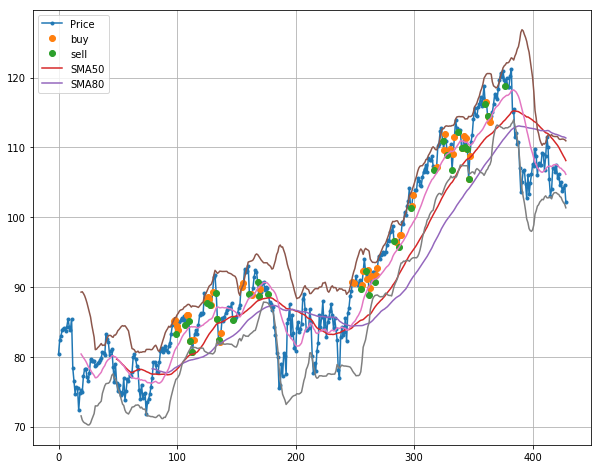

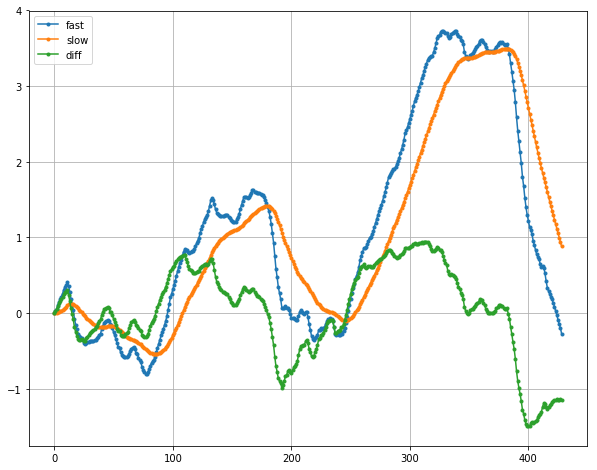

CRON
CRON 136.06089743589752 



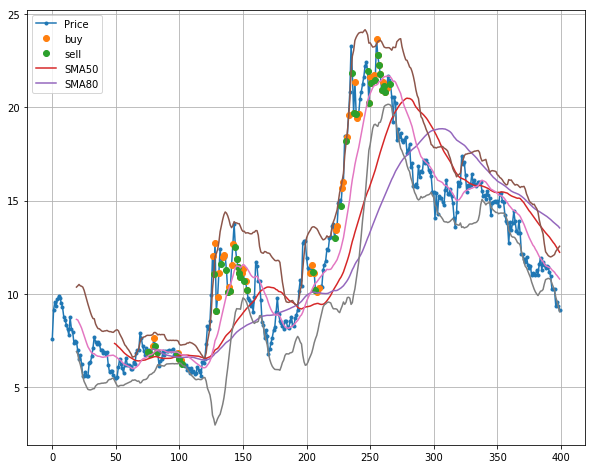

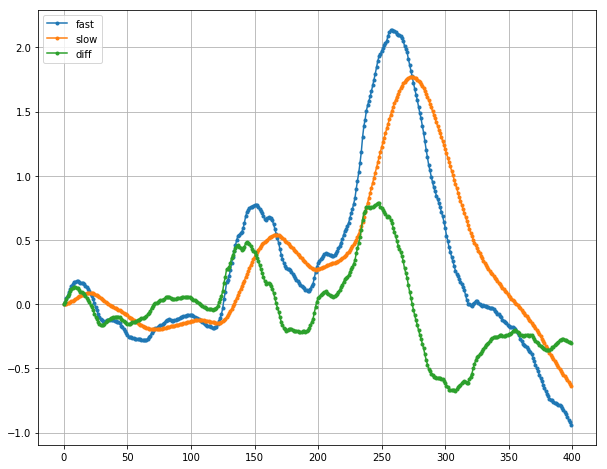

177.8795398833162


In [134]:
#long term trading
# %matplotlib notebook
%matplotlib inline
symbols = ['TSLA', 'OXY', 'ARKQ', 'DASH', 'ABNB', 'CRON', 'ORBC', 'HOME', 'REAL', 'SQNS', 'GOCO', 'VLDR', 'WMT', 'BA',
           'AAPL', 'TDOC', 'NIO', 'FB', 'MSFT', 'BABA', 'AMD', 'V', 'JPM', 'BAC', 'CCL', 'NVDA', 'DOCU', 'CRM', 
           'PYPL', 'U', 'PLUG', 'ZM', 'GOOG', 'AMZN', 'UAL']   
# symbols = ['UAL', 'BABA', 'CRON']
symbols = ['PYPL', 'CRON']

highest_prices = {}
for symbol in symbols: 
    highest_prices[symbol] = 0

revenue = 0
for symbol in symbols:
    print(symbol)
    tsla = api.get_barset(symbol, 'day', start = '2018-01-15T11:00:00-05:00', end = '2019-09-29T16:00:00-05:00').df
#     tsla = api.get_barset(symbol, '5Min', start = '2019-03-14T9:00:00-05:00', end = '2019-06-14T16:00:00-05:00').df
    if tsla.shape[0] < 70: continue
    process_stock_df(tsla)
    SMA(tsla, 5,  True)
    SMA(tsla, 10,  True)
    SMA(tsla, 20,  True) 
    SMA(tsla, 30,  True)
    SMA(tsla, 50,  True)
    SMA(tsla, 80,  True)
    Bollinger_Band(tsla, 20, True)
    MACD(tsla)
    VWAP(tsla)  
    price_volume_ratio(tsla)  #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!NEW!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    data = tsla['close']
    EMA12 = data.ewm(span=12, adjust=False).mean()
    EMA26 = data.ewm(span=26, adjust=False).mean()
    tsla['EMA12'] = EMA12
    tsla['EMA26'] = EMA26

    tsla['buyin'] = [np.nan] * tsla.shape[0]
    tsla['sellout'] = [np.nan] * tsla.shape[0]
    stock = 0
    res = 0


    buyin = []
    jump = 0
    for i in range(70, tsla.shape[0]):

#         buy_score, macd_main, macd_sub, bb_main, bb_sub, trend_main, trend_sub = buyin_strategy_combined_v4(tsla, i)
        buy_score = buyin_strategy_combined_day(tsla, i)
#         if buy_score > 0.49:
#             print('buy', i, tsla.iloc[i]['close'], tsla.iloc[i]['Time']) 
        if buy_score > 0.49 and len(buyin) < 2:
            buyin.append(tsla.iloc[i]['close'])
            tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
        if buy_score >= 0.99 and len(buyin) < 3:
            buyin.append(tsla.iloc[i]['close'])
            tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
                    
        if buyin:
            cost_basis = sum(buyin)/len(buyin)
            highest_pri = max(cost_basis, highest_prices[symbol] ,tsla.iloc[i-1]['close'])
            highest_prices[symbol] = highest_pri
            try:
                sell_score= sell_strategy_combined_day(tsla, i, cost_basis, highest_pri)
            except:
                print("what error is this?!", i, sell_score)
    #             sell_score = 0
                pass
#             if 1.09 > sell_score >= 0.99: print(i, 'SELL', sell_score)
            if sell_score >= 0.99 and buyin:
#                 print(i, buyin, tsla.iloc[i]['close'], tsla.iloc[i]['Time'])
                tsla.loc[i, 'sellout'] = tsla.iloc[i]['close']
                res += sum([tsla.iloc[i]['close'] - buyp for buyp in buyin])
                buyin = []
                highest_prices[symbol] = 0
            
    res = res * 100/tsla.iloc[i-1]['close'] #归一化
    revenue += res
    print(symbol, res, '\n')

    plt.figure(figsize=(10,8))
    plt.plot(tsla.index, tsla['close'], MARKER = '.', label='Price')
    plt.plot(tsla.index, tsla['buyin'], 'o', label='buy')
    plt.plot(tsla.index, tsla['sellout'], 'o', label='sell')
#     plt.plot(tsla.index, tsla['vwap'], label='vwap')
    plt.plot(tsla.index, tsla['SMA50'], label='SMA50')
    plt.plot(tsla.index, tsla['SMA80'], label='SMA80')
#     plt.plot(tsla.index, tsla['SMA10'], label='SMA10')
#     plt.plot(tsla.index, tsla['SMA30'], label='SMA30')
    plt.plot(tsla.index, tsla[['bbHigh', 'bbMid', 'bbLow']])
    # plt.plot(tsla.index, tsla[['EMA12', 'EMA26']], label=['EMA12', 'EMA26'])
#     plt.xlim([0, 200])
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

    plt.figure(figsize=(10,8))
    plt.plot(tsla.index, tsla['MACD_fast'], marker='.', label='fast')
    plt.plot(tsla.index, tsla['MACD_slow'], marker='.', label='slow')
    plt.plot(tsla.index, tsla['MACD_diff'], marker='.', label='diff')
#     plt.xlim([0, 200])
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()
    
#     plt.figure(figsize=(16,8))
#     plt.plot(tsla.index, tsla['pvr'], marker='.', label='pvr')
# #     plt.yscale('log')
# #     plt.ylim([-0.2, 0.2])
#     plt.xlim([0, 200])
#     plt.legend(loc='upper left')
#     plt.grid()
#     plt.show()
    
print(revenue)



In [83]:
tsla

,Time,open,high,low,close,volume,SMA5,SMA10,SMA20,SMA30,...,bbLow,MACD_fast,MACD_slow,MACD_diff,vwap,pvr,EMA12,EMA26,buyin,sellout
0,2019-06-28 00:00:00-04:00,28.000,30.0500,27.0400,28.800,22046399,NaN,NaN,NaN,NaN,...,NaN,0.000000,0.000000,0.000000,28.800,NaN,28.800000,28.800000,NaN,NaN
1,2019-07-01 00:00:00-04:00,29.470,29.4900,25.1450,26.550,3567838,NaN,NaN,NaN,NaN,...,NaN,-0.030357,-0.001481,-0.028876,26.550,NaN,28.453846,28.633333,NaN,NaN
2,2019-07-02 00:00:00-04:00,26.650,26.6965,25.0600,25.670,1430905,NaN,NaN,NaN,NaN,...,NaN,-0.070829,-0.004864,-0.065965,25.670,0.001959,28.025562,28.413827,NaN,NaN
3,2019-07-03 00:00:00-04:00,26.000,26.2000,25.2000,25.500,420077,NaN,NaN,NaN,NaN,...,NaN,-0.111225,-0.010052,-0.101173,25.500,0.003473,27.637014,28.197988,NaN,NaN
4,2019-07-05 00:00:00-04:00,25.410,26.6200,25.0700,26.500,1480679,26.604,NaN,NaN,NaN,...,NaN,-0.135732,-0.016183,-0.119549,26.500,0.003371,27.462089,28.072211,NaN,NaN
5,2019-07-08 00:00:00-04:00,26.350,26.5000,25.8000,25.920,1100795,26.028,NaN,NaN,NaN,...,NaN,-0.166557,-0.023518,-0.143039,25.920,0.002984,27.224844,27.912788,NaN,NaN
6,2019-07-09 00:00:00-04:00,25.910,25.9100,25.1311,25.380,756216,25.794,NaN,NaN,NaN,...,NaN,-0.202774,-0.032262,-0.170511,25.380,0.002349,26.941022,27.725174,NaN,NaN
7,2019-07-10 00:00:00-04:00,25.360,26.6300,25.2101,26.400,484549,25.940,NaN,NaN,NaN,...,NaN,-0.222998,-0.041566,-0.181432,26.400,0.004133,26.857788,27.627013,NaN,NaN
8,2019-07-11 00:00:00-04:00,26.610,26.8099,25.4000,25.650,446452,25.970,NaN,NaN,NaN,...,NaN,-0.252009,-0.051832,-0.200177,25.650,0.006425,26.671974,27.480568,NaN,NaN
9,2019-07-12 00:00:00-04:00,25.470,26.0000,25.3150,25.790,533976,25.828,26.2160,NaN,NaN,...,NaN,-0.277273,-0.062829,-0.214444,25.790,0.006279,26.536286,27.355341,NaN,NaN


WMT
158 [] 140.4693
WMT 0.0 



<IPython.core.display.Javascript object>


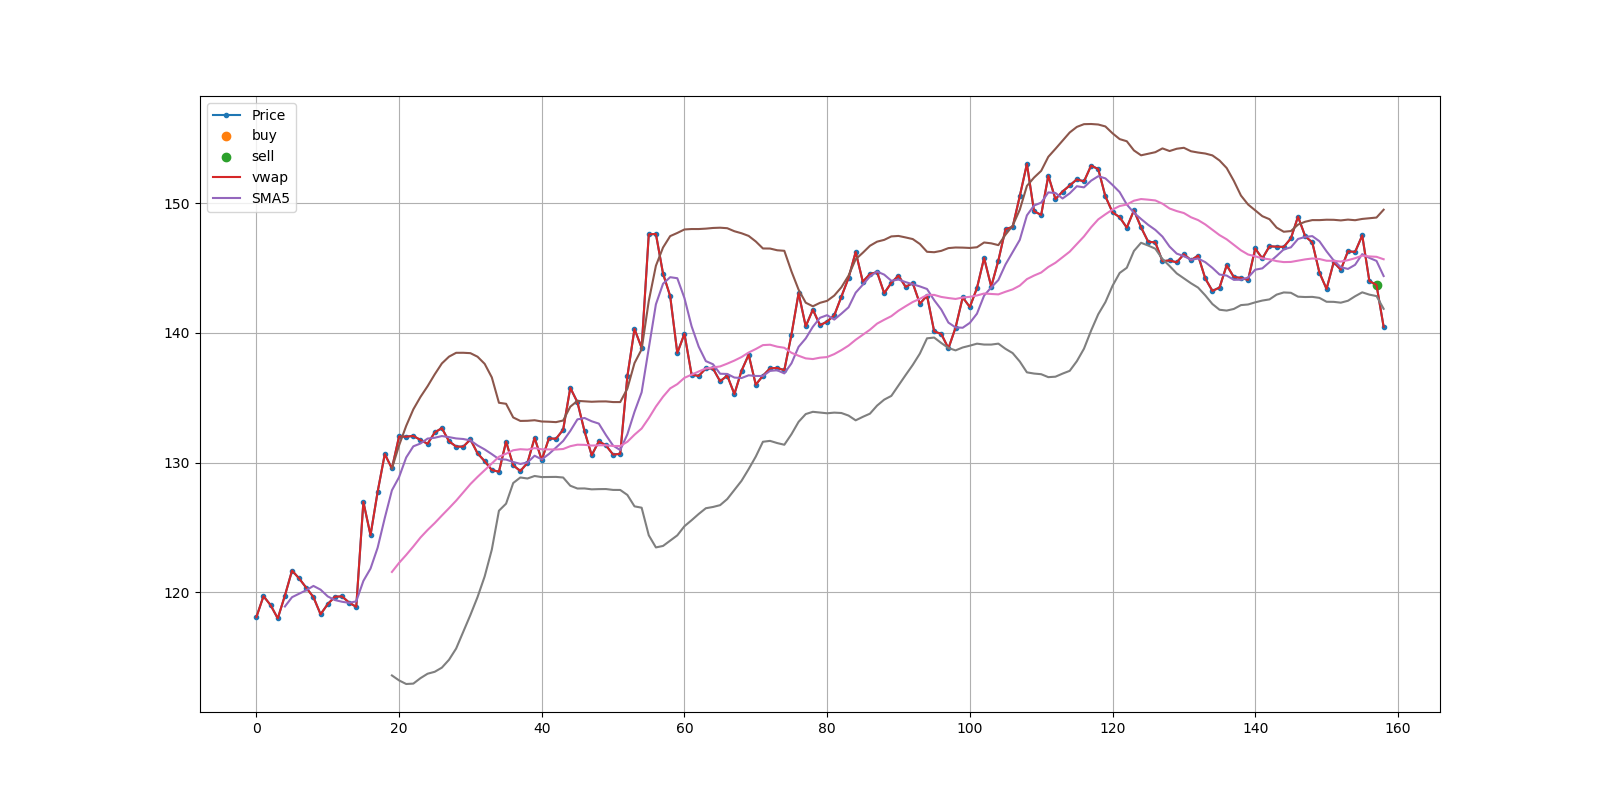

<IPython.core.display.Javascript object>


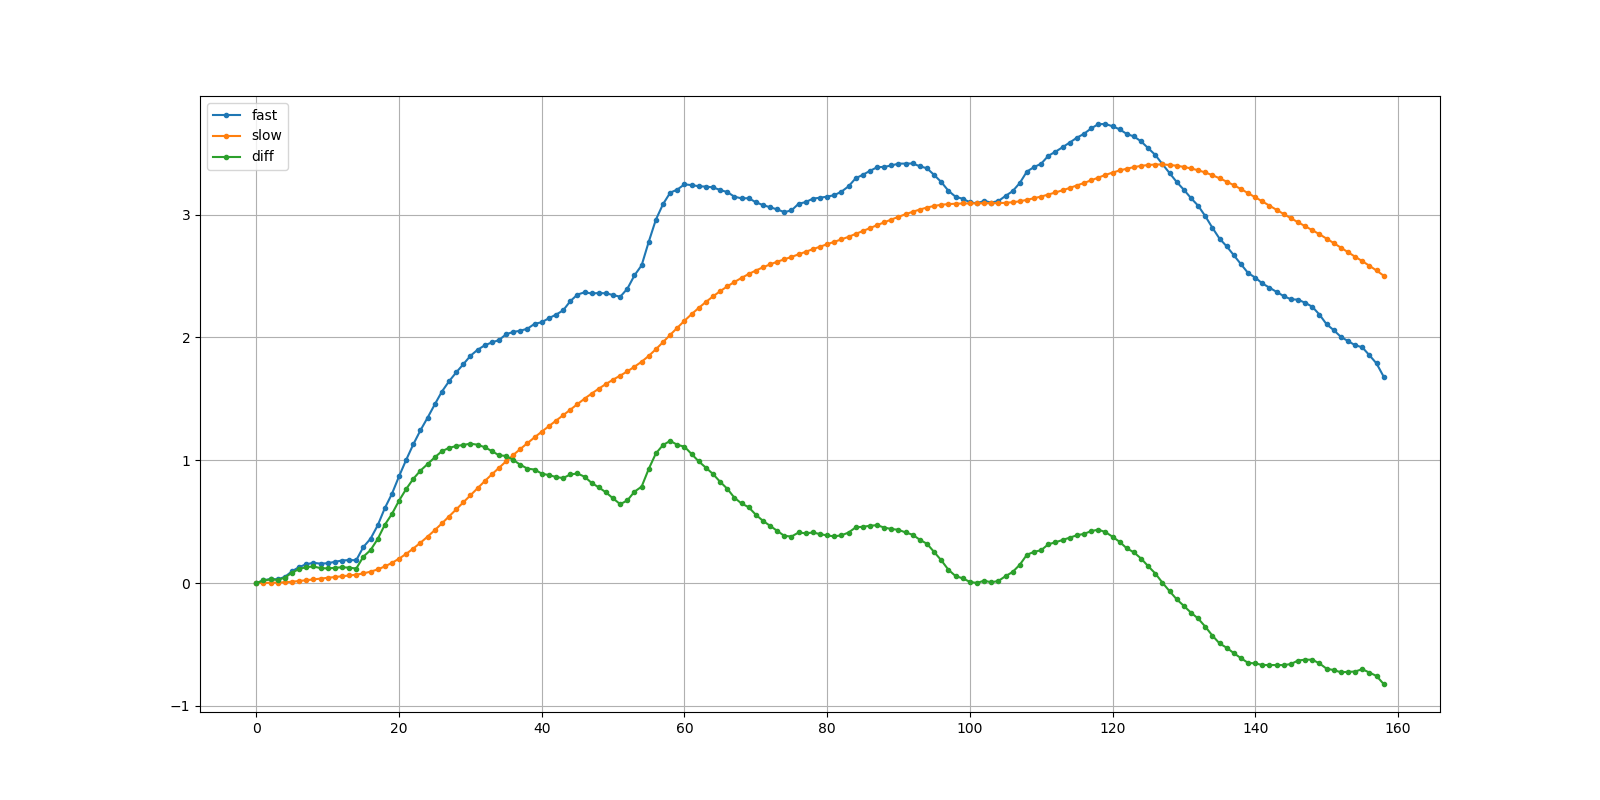

TSLA
54 BUY 0.5 0 [True, True, True, False] 1 [True, True, True, False, False, True] 1 [True, True, True, True, False, False]
54 [498.51] 498.51
134 BUY 0.5 0 [False, True, True, False] 0 [False, True, True, True, True, True] 1 [False, True, True, True, True, True]
135 [645.98] 661.66
158 [] 793.311
TSLA 0.0 



<IPython.core.display.Javascript object>


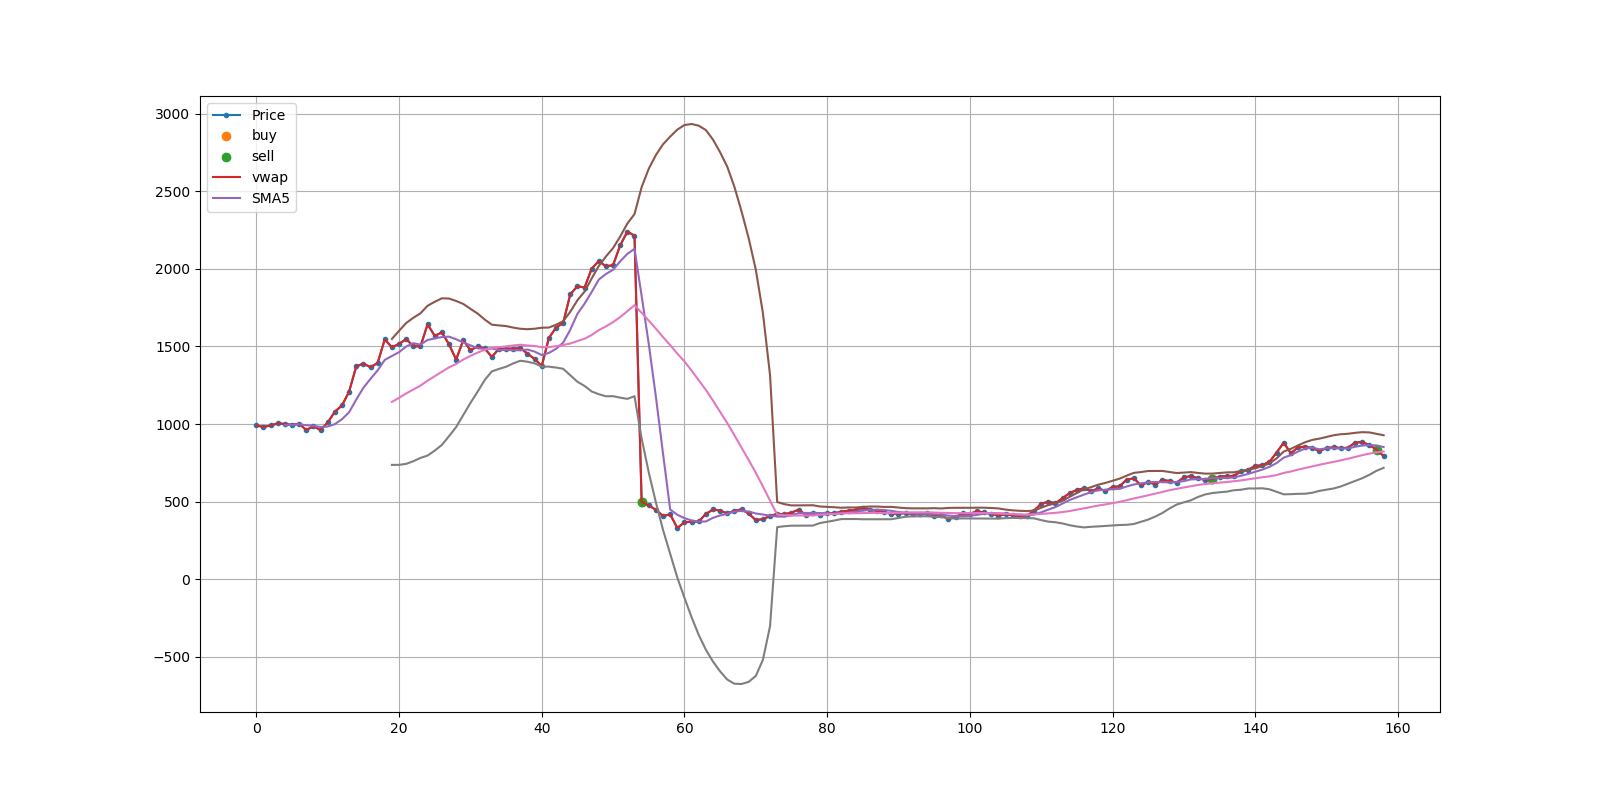

<IPython.core.display.Javascript object>


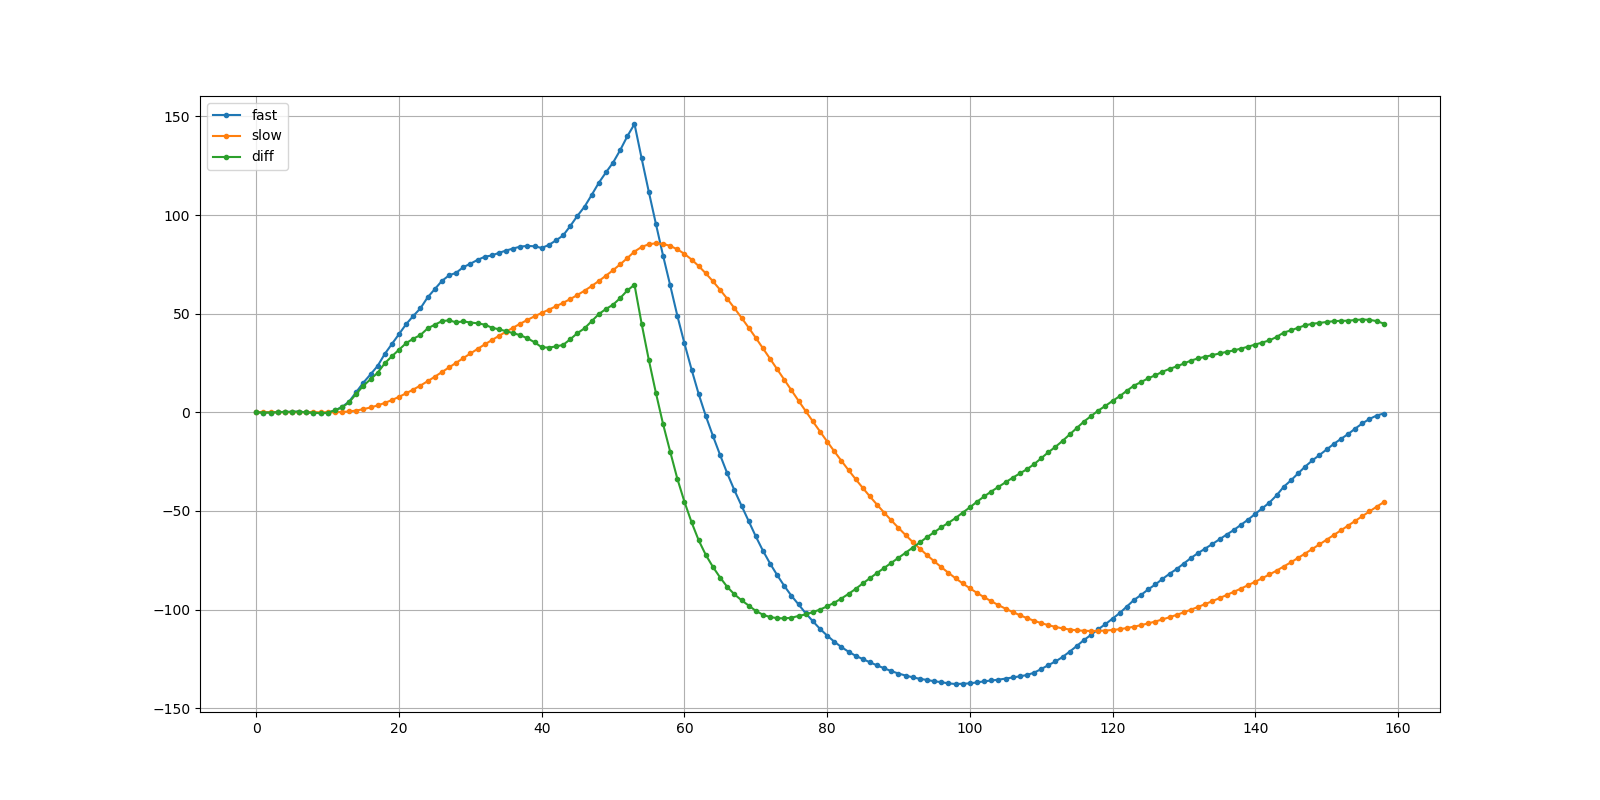

BA
133 BUY 0.5 0 [True, True, False, False] 0 [True, True, False, False, False, True] 1 [True, True, True, True, False, False]
134 [218.82] 219.56
158 [] 194.11
BA 0.0 



<IPython.core.display.Javascript object>


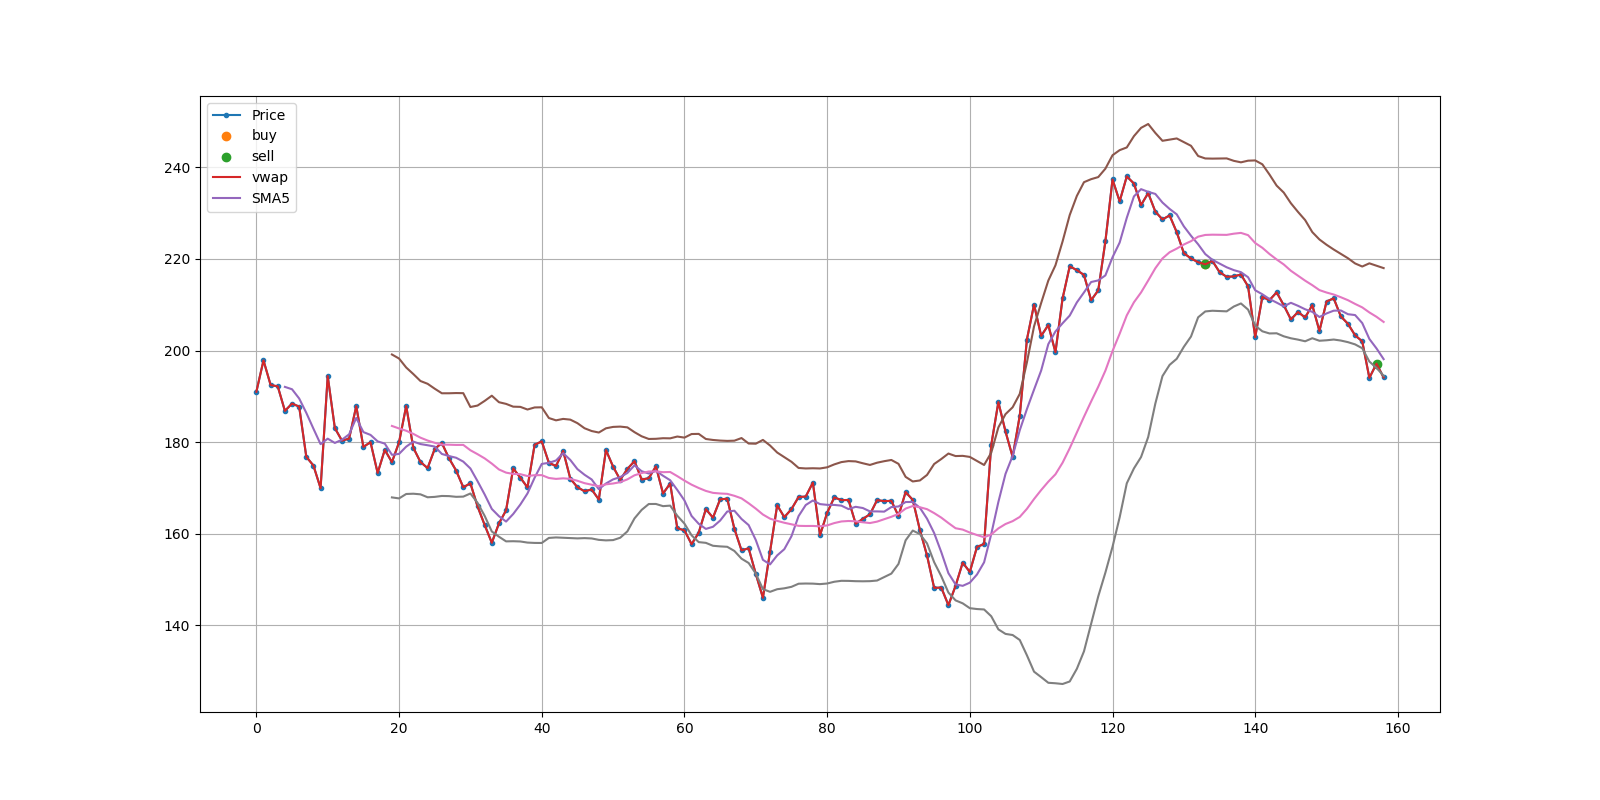

<IPython.core.display.Javascript object>


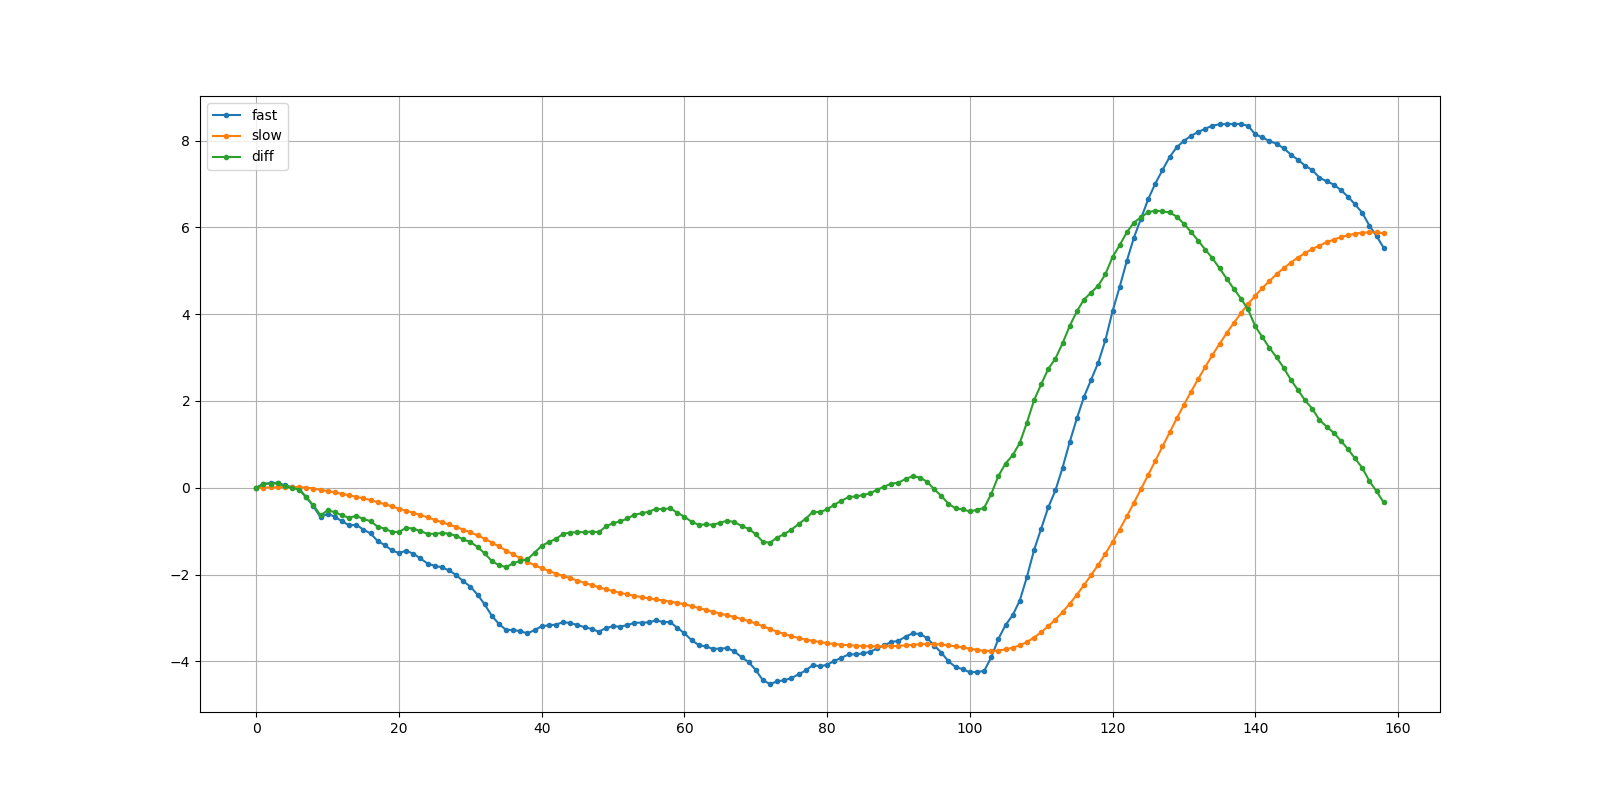

0.0


In [31]:
#short term(day) trading
symbols = ['TSLA', 'OXY', 'ARKQ', 'DASH', 'ABNB', 'CRON', 'ORBC', 'HOME', 'REAL', 'SQNS', 'GOCO', 'VLDR', 'WMT', 'BA',
           'AAPL', 'TDOC', 'NIO', 'FB', 'MSFT', 'BABA', 'AMD', 'V', 'JPM', 'TSLA', 'BAC', 'CCL', 'NVDA', 'DOCU', 'CRM', 
           'PYPL', 'U', 'PLUG', 'ZM', 'GOOG', 'AMZN', 'UAL']   
# symbols = ['TDOC', 'DOCU', 'SQNS', 'GOCO']
# symbols = ['WMT', 'TSLA', 'BA']

highest_prices = {}
for symbol in symbols:
    highest_prices[symbol] = 0

revenue = 0
for symbol in symbols:
    print(symbol)
    tsla = api.get_barset(symbol, '5Min', start = '2021-01-15T11:00:00-05:00', end = '2021-01-20T16:00:00-05:00').df
#     tsla = api.get_barset(symbol, '5Min', start = '2019-03-14T9:00:00-05:00', end = '2019-06-14T16:00:00-05:00').df
    if tsla.shape[0] < 60: continue
    process_stock_df(tsla)
    SMA(tsla, 5,  True)
    SMA(tsla, 10,  True)
    SMA(tsla, 20,  True) 
    SMA(tsla, 30,  True)
    Bollinger_Band(tsla, 20, True)
    MACD(tsla)
    VWAP(tsla)  
    price_volume_ratio(tsla)  #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!NEW!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    data = tsla['close']
    EMA12 = data.ewm(span=12, adjust=False).mean()
    EMA26 = data.ewm(span=26, adjust=False).mean()
    tsla['EMA12'] = EMA12
    tsla['EMA26'] = EMA26

    tsla['buyin'] = [np.nan] * tsla.shape[0]
    tsla['sellout'] = [np.nan] * tsla.shape[0]
    stock = 0
    res = 0


    buyin = []
    jump = 0
    for i in range(50, tsla.shape[0]):

    #     if tsla.iloc[i-lag_buy]['MACD_diff'] < 0 and \
    #        tsla.iloc[i]['MACD_diff'] > 0 and \
    #         tsla.iloc[i]['MACD_fast'] > macd_boundry_buy and \
    #         abs(sum(tsla.iloc[i-lag_buy : i]['MACD_diff'])/lag_buy) > diff_threshold_buy and\
    #         (tsla.iloc[i]['SMA30'] - tsla.iloc[i-lag_buy]['SMA30']) / tsla.iloc[i]['SMA30'] > 0.002: 

        if i == tsla.index[-1] or str(tsla.iloc[i]['Time']).split()[0] != str(tsla.iloc[i-1]['Time']).split()[0] and buyin:
            tsla.loc[i-1, 'sellout'] = tsla.iloc[i-1]['close']
            print(i, buyin, tsla.iloc[i]['close'])
            res += sum([tsla.iloc[i-1]['close'] - buyp for buyp in buyin])
            buyin = []
            highest_prices[symbol] = 0
            jump = i + 5
            continue
        elif i < jump: continue


        buy_score, macd_main, macd_sub, bb_main, bb_sub, trend_main, trend_sub = buyin_strategy_combined_v4(tsla, i)
        if buy_score > 0.49:# or \
#         (macd_main and sum(macd_sub) >= 2) or \
#         (bb_main and sum(bb_sub) >= 3):
            print(i, 'BUY', buy_score, macd_main, macd_sub, bb_main, bb_sub, trend_main, trend_sub) 
        if buy_score > 0.49 and len(buyin) < 2:
            buyin.append(tsla.iloc[i]['close'])
            tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
        if buy_score >= 0.99 and len(buyin) < 4:
            buyin.append(tsla.iloc[i]['close'])
            tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
        
        if buyin:
            cost_basis = sum(buyin)/len(buyin)
            highest_pri = max(cost_basis, highest_prices[symbol] ,tsla.iloc[i-1]['close'])
            highest_prices[symbol] = highest_pri
            try:
                sell_score= sell_strategy_combined_v4(tsla, i, cost_basis, highest_pri)
            except:
                print("what error is this?!", i, sell_score)
    #             sell_score = 0
                pass
            if 1.09 > sell_score >= 0.99: print(i, 'SELL', sell_score)
            if sell_score >= 0.99 and buyin:
                print(i, buyin, tsla.iloc[i]['close'])
                tsla.loc[i, 'sellout'] = tsla.iloc[i]['close']
                res += sum([tsla.iloc[i]['close'] - buyp for buyp in buyin])
                buyin = []
                highest_prices[symbol] = 0
            
    res = res * 100/tsla.iloc[i-1]['close'] #归一化
    revenue += res
    print(symbol, res, '\n')

    plt.figure(figsize=(16,8))
    plt.plot(tsla.index, tsla['close'], MARKER = '.', label='Price')
    plt.plot(tsla.index, tsla['buyin'], 'o', label='buy')
    plt.plot(tsla.index, tsla['sellout'], 'o', label='sell')
    plt.plot(tsla.index, tsla['vwap'], label='vwap')
    plt.plot(tsla.index, tsla['SMA5'], label='SMA5')
#     plt.plot(tsla.index, tsla['SMA10'], label='SMA10')
#     plt.plot(tsla.index, tsla['SMA30'], label='SMA30')
    plt.plot(tsla.index, tsla[['bbHigh', 'bbMid', 'bbLow']])
    # plt.plot(tsla.index, tsla[['EMA12', 'EMA26']], label=['EMA12', 'EMA26'])
#     plt.xlim([0, 200])
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

    plt.figure(figsize=(16,8))
    plt.plot(tsla.index, tsla['MACD_fast'], marker='.', label='fast')
    plt.plot(tsla.index, tsla['MACD_slow'], marker='.', label='slow')
    plt.plot(tsla.index, tsla['MACD_diff'], marker='.', label='diff')
#     plt.xlim([0, 200])
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()
    
#     plt.figure(figsize=(16,8))
#     plt.plot(tsla.index, tsla['pvr'], marker='.', label='pvr')
# #     plt.yscale('log')
# #     plt.ylim([-0.2, 0.2])
#     plt.xlim([0, 200])
#     plt.legend(loc='upper left')
#     plt.grid()
#     plt.show()
    
print(revenue)



In [ ]:
67.79356044662298
36.9009873651206

In [17]:
# REAL TRADING
symbols = ['VLDR', 'WMT', 'BA', 'AAPL', 'TDOC', 'NIO', 'FB', 'MSFT', 'BABA', 'AMD', 'V', 'JPM', 'TSLA', 'BAC', 'CCL',
         'NVDA', 'DOCU', 'CRM', 'PYPL', 'U', 'PLUG', 'ZM', 'GOOG', 'AMZN', 'UAL', 'OXY', 'ARKQ', 'DASH', 'ABNB', 'CRON',
         'ORBC', 'HOME', 'REAL', 'SQNS', 'GOCO', 'PIPP']  

highest_prices = {}
for symbol in symbols:
    highest_prices[symbol] = 0

# combined strategies
benjin = float(api.get_account().last_equity)
clock = api.get_clock()

time_stamps = dict([(symbol, '0') for symbol in stocks])

t = 0
while not clock.is_open and t < 10e9:
    try:
        if t % 120 == 0:
            print(clock.timestamp)
        t += 1
        time.sleep(30)
        clock = api.get_clock()
    except:
        time.sleep(60)
        continue
        

print('Market is Open Now')
time.sleep(6 * 60) #wait a while to start trading

print('Start Trading Now')
clock = api.get_clock()
while clock.is_open:
    try:
        
        clock = api.get_clock()
    #     print(clock.timestamp, convert_time_to_num_minute(clock.timestamp))
        if convert_time_to_num_minute(clock.timestamp) > 155500:  #15:58:00
            print('Market Closing, Selling all Stocks...')
            for pos in api.list_positions():
                symbol = pos.symbol
                cost_basis = get_position_avg_cost_basis(symbol)
                sell_qty = int(pos.qty)
                api.submit_order(
                                symbol = symbol,
                                qty = sell_qty,
                                side = 'sell',
                                type = 'market',
                                time_in_force = 'gtc')
                print('Sold ' + symbol + ' of Qty: ', sell_qty, 'at Price: ', api.get_last_trade(symbol).price, '\n', 
                          'Avg cost basis: ', cost_basis, 
                          'Revenue: ', (float(api.get_last_trade(symbol).price) - cost_basis) * sell_qty)
            print("清仓完成")
            break

        for symbol in stocks:
            time.sleep(3)
        #     symbol = 'WMT'
            tsla = api.get_barset(symbol, '5Min', after = '2021-01-14T10:00:00-05:00').df
            if tsla.shape[0] < 1: continue
            process_stock_df(tsla)

            if str(tsla['Time'][-1]) == time_stamps[symbol]: continue
            else: time_stamps[symbol] = str(tsla['Time'][-1])

    #####记得每天从测试脚本更新一下步骤和参数！！！##########################################################################################
            SMA(tsla, 5,  True)
            SMA(tsla, 10,  True)
            SMA(tsla, 20,  True)
            SMA(tsla, 30,  True)
            Bollinger_Band(tsla, 20, True)
            MACD(tsla)
            VWAP(tsla)

            buyin_threshold = 0.49
            sell_threshold = 0.99
    ########################################################################################################################################       
            tsla['buyin'] = [np.nan] * tsla.shape[0]
            tsla['sellout'] = [np.nan] * tsla.shape[0]
            res = 0

            buyin = []

            i = tsla.index[-1]
            buy_score = buyin_strategy_combined_v4(tsla, i)[0]
        #     if buy_score > 0: print(buy_score) 
            if buy_score > buyin_threshold and get_position_cost_basis(symbol) < benjin * 0.1:
                buyin_qty = float(api.get_account().cash)*0.06 // float(api.get_last_trade(symbol).price)
                if buyin_qty > 0:
                    api.submit_order(
                                    symbol = symbol,
                                    qty = buyin_qty,
                                    side = 'buy',
                                    type = 'market',
                                    time_in_force = 'gtc')
                    print('Buy In ' + symbol + ' of Qty: ', buyin_qty, 'at Price: ', api.get_last_trade(symbol).price, 
                          '  Buy Score: ', buy_score, clock.timestamp)
                time.sleep(3)
        #             buyin.append(tsla.iloc[i]['close'])
        #             tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
            if buy_score >= buyin_threshold * 2 and get_position_cost_basis(symbol) < benjin * 0.15:
                buyin_qty = float(api.get_account().cash)*0.1 // float(api.get_last_trade(symbol).price)
                if buyin_qty > 0:
                    api.submit_order(
                                    symbol = symbol,
                                    qty = buyin_qty,
                                    side = 'buy',
                                    type = 'market',
                                    time_in_force = 'gtc')
                    print('Buy In ' + symbol + ' of Qty: ', buyin_qty, 'at Price: ', api.get_last_trade(symbol).price, 
                          '  Buy Score: ', buy_score, clock.timestamp)
                time.sleep(1)
            
            if get_position_avg_cost_basis(symbol) > 0:
                cost_basis = get_position_avg_cost_basis(symbol)
                highest_prices[symbol] = highest_pri = max(cost_basis, tsla.iloc[i]['close'], highest_prices[symbol])
                sell_score = sell_strategy_combined_v4(tsla, i, cost_basis, highest_pri)
            #     if sell_score > 0: print(sell_score)
                if sell_score >= sell_threshold and get_position_qty(symbol):
                    sell_qty = get_position_qty(symbol)
                    cost_basis = get_position_avg_cost_basis(symbol)
                    api.submit_order(
                                    symbol = symbol,
                                    qty = sell_qty,
                                    side = 'sell',
                                    type = 'market',
                                    time_in_force = 'gtc')
                    highest_prices[symbol] = 0
                    print('Sold ' + symbol + ' of Qty: ', sell_qty, 'at Price: ', api.get_last_trade(symbol).price, '\n', 
                          'Avg cost basis: ', cost_basis, 
                          'Revenue: ', (float(api.get_last_trade(symbol).price) - cost_basis) * sell_qty, 
                            '  Sell Score: ', sell_score, clock.timestamp)
                    time.sleep(1)
    #         print(clock.timestamp, symbol,  'Buy Score: ', buy_score, 'Sell Score: ', sell_score)

        #             tsla.loc[i, 'sellout'] = tsla.iloc[i]['close']
        #             res += sum([tsla.iloc[i]['close'] - buyp for buyp in buyin])
        #             buyin = []
        #                 print(i, 'out', tsla.iloc[i]['close'], tsla.iloc[i]['Time'], tsla.iloc[i]['sellout'])
        #     print(symbol, res)
        #     revenue += res
        # print('total revenue: ', revenue)

        #     plt.figure(figsize=(12,8))
        #     plt.plot(tsla['Time'], tsla['MACD_fast'], marker='.', label='fast')
        #     plt.plot(tsla['Time'], tsla['MACD_slow'], marker='.', label='slow')
        #     plt.plot(tsla['Time'], tsla['MACD_diff'], marker='.', label='diff')

        #     plt.legend(loc='upper left')
        #     plt.grid()

        #     plt.figure(figsize=(12,8))
        #     plt.plot(tsla['Time'], tsla['close'], label='Price')
        #     plt.plot(tsla['Time'], tsla['buyin'], 'o', label='buy')
        #     plt.plot(tsla['Time'], tsla['sellout'], 'o', label='sell')
        #     plt.plot(tsla['Time'], tsla[['bbHigh', 'bbLow']])
        #     plt.legend(loc='upper left')
        #     plt.grid()
        #     plt.show()
    except: 
        print(symbol, clock.timestamp)
        continue
        



2021-01-22 03:28:48.966616821-05:00
2021-01-22 04:29:00.331168555-05:00
2021-01-22 05:29:12.048765510-05:00
2021-01-22 06:30:24.208283158-05:00
2021-01-22 07:30:35.811697670-05:00
2021-01-22 08:30:47.577200124-05:00
Market is Open Now
Start Trading Now
Buy In ZM of Qty:  15.0 at Price:  382.41   Buy Score:  0.5 2021-01-22 09:36:29.641459584-05:00
Sold ZM of Qty:  15 at Price:  378.03 
 Avg cost basis:  381.93 Revenue:  -58.50000000000051   Sell Score:  100 2021-01-22 09:50:28.449707881-05:00
Buy In U of Qty:  39.0 at Price:  153.66   Buy Score:  0.5 2021-01-22 09:52:03.008779293-05:00
Buy In CRM of Qty:  24.0 at Price:  226.8   Buy Score:  0.5 2021-01-22 10:05:59.263729293-05:00
Buy In MSFT of Qty:  23.0 at Price:  229.75   Buy Score:  0.5 2021-01-22 10:16:54.108809973-05:00
Buy In MSFT of Qty:  21.0 at Price:  229.74   Buy Score:  0.5 2021-01-22 10:21:32.523357502-05:00
Buy In PYPL of Qty:  18.0 at Price:  253.15   Buy Score:  0.5 2021-01-22 10:21:32.523357502-05:00
Buy In TDOC of Qty

OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00


OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00


OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00


OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00


OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00


OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00


OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00


OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00


OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00


OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00


OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00


OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00


OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00


OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00


OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00


OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00


OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00
OXY 2021-01-22 14:28:39.490726078-05:00


In [29]:
a = 'b'
b = 'b'
a > b

False

In [16]:
clock.timestamp

Timestamp('2021-01-21 03:10:01.858437513-0500', tz='pytz.FixedOffset(-300)')

In [18]:
# REAL TRADING
symbols = ['VLDR', 'WMT', 'BA', 'AAPL', 'TDOC', 'NIO', 'FB', 'MSFT', 'BABA', 'AMD', 'V', 'JPM', 'TSLA', 'BAC', 'CCL',
         'NVDA', 'DOCU', 'CRM', 'PYPL', 'U', 'PLUG', 'ZM', 'GOOG', 'AMZN', 'UAL', 'OXY', 'ARKQ', 'DASH', 'ABNB', 'CRON',
         'ORBC', 'HOME', 'REAL', 'SQNS', 'GOCO', 'PIPP']  

highest_prices = {}
for symbol in symbols:
    highest_prices[symbol] = 0

# combined strategies
benjin = float(api.get_account().last_equity)
clock = api.get_clock()

time_stamps = dict([(symbol, '0') for symbol in stocks])

t = 0
while not clock.is_open and t < 10e9:
    try:
        t += 1
        time.sleep(30)
        clock = api.get_clock()
    except:
        time.sleep(60)
        continue
        

print('Market is Open Now')
time.sleep(6 * 60) #wait a while to start trading

print('Start Trading Now')
clock = api.get_clock()
while clock.is_open:
    try:
        
        clock = api.get_clock()
    #     print(clock.timestamp, convert_time_to_num_minute(clock.timestamp))
        if convert_time_to_num_minute(clock.timestamp) > 155500:  #15:58:00
            print('Market Closing, Selling all Stocks...')
            for pos in api.list_positions():
                symbol = pos.symbol
                cost_basis = get_position_avg_cost_basis(symbol)
                sell_qty = int(pos.qty)
                api.submit_order(
                                symbol = symbol,
                                qty = sell_qty,
                                side = 'sell',
                                type = 'market',
                                time_in_force = 'gtc')
                print('Sold ' + symbol + ' of Qty: ', sell_qty, 'at Price: ', api.get_last_trade(symbol).price, '\n', 
                          'Avg cost basis: ', cost_basis, 
                          'Revenue: ', (float(api.get_last_trade(symbol).price) - cost_basis) * sell_qty)
            print("清仓完成")
            break

        for symbol in stocks:
            time.sleep(3)
        #     symbol = 'WMT'
            tsla = api.get_barset(symbol, '5Min', after = '2021-01-14T10:00:00-05:00').df
            if tsla.shape[0] < 1: continue
            process_stock_df(tsla)

            if str(tsla['Time'][-1]) == time_stamps[symbol]: continue
            else: time_stamps[symbol] = str(tsla['Time'][-1])

    #####记得每天从测试脚本更新一下步骤和参数！！！##########################################################################################
            SMA(tsla, 5,  True)
            SMA(tsla, 10,  True)
            SMA(tsla, 20,  True)
            SMA(tsla, 30,  True)
            Bollinger_Band(tsla, 20, True)
            MACD(tsla)
            VWAP(tsla)

            buyin_threshold = 0.49
            sell_threshold = 0.99
    ########################################################################################################################################       
            tsla['buyin'] = [np.nan] * tsla.shape[0]
            tsla['sellout'] = [np.nan] * tsla.shape[0]
            res = 0

            buyin = []

            i = tsla.index[-1]
            buy_score = buyin_strategy_combined_v4(tsla, i)[0]
        #     if buy_score > 0: print(buy_score) 
            if buy_score > buyin_threshold and get_position_cost_basis(symbol) < benjin * 0.1:
                buyin_qty = float(api.get_account().cash)*0.06 // float(api.get_last_trade(symbol).price)
                if buyin_qty > 0:
                    api.submit_order(
                                    symbol = symbol,
                                    qty = buyin_qty,
                                    side = 'buy',
                                    type = 'market',
                                    time_in_force = 'gtc')
                    print('Buy In ' + symbol + ' of Qty: ', buyin_qty, 'at Price: ', api.get_last_trade(symbol).price, 
                          '  Buy Score: ', buy_score, clock.timestamp)
                time.sleep(3)
        #             buyin.append(tsla.iloc[i]['close'])
        #             tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
            if buy_score >= buyin_threshold * 2 and get_position_cost_basis(symbol) < benjin * 0.15:
                buyin_qty = float(api.get_account().cash)*0.1 // float(api.get_last_trade(symbol).price)
                if buyin_qty > 0:
                    api.submit_order(
                                    symbol = symbol,
                                    qty = buyin_qty,
                                    side = 'buy',
                                    type = 'market',
                                    time_in_force = 'gtc')
                    print('Buy In ' + symbol + ' of Qty: ', buyin_qty, 'at Price: ', api.get_last_trade(symbol).price, 
                          '  Buy Score: ', buy_score, clock.timestamp)
                time.sleep(1)
            
            if get_position_avg_cost_basis(symbol) > 0:
                cost_basis = get_position_avg_cost_basis(symbol)
                highest_prices[symbol] = highest_pri = max(cost_basis, tsla.iloc[i]['close'], highest_prices[symbol])
                sell_score = sell_strategy_combined_v4(tsla, i, cost_basis, highest_pri)
            #     if sell_score > 0: print(sell_score)
                if sell_score >= sell_threshold and get_position_qty(symbol):
                    sell_qty = get_position_qty(symbol)
                    cost_basis = get_position_avg_cost_basis(symbol)
                    api.submit_order(
                                    symbol = symbol,
                                    qty = sell_qty,
                                    side = 'sell',
                                    type = 'market',
                                    time_in_force = 'gtc')
                    highest_prices[symbol] = 0
                    print('Sold ' + symbol + ' of Qty: ', sell_qty, 'at Price: ', api.get_last_trade(symbol).price, '\n', 
                          'Avg cost basis: ', cost_basis, 
                          'Revenue: ', (float(api.get_last_trade(symbol).price) - cost_basis) * sell_qty, 
                            '  Sell Score: ', sell_score, clock.timestamp)
                    time.sleep(1)
    #         print(clock.timestamp, symbol,  'Buy Score: ', buy_score, 'Sell Score: ', sell_score)

        #             tsla.loc[i, 'sellout'] = tsla.iloc[i]['close']
        #             res += sum([tsla.iloc[i]['close'] - buyp for buyp in buyin])
        #             buyin = []
        #                 print(i, 'out', tsla.iloc[i]['close'], tsla.iloc[i]['Time'], tsla.iloc[i]['sellout'])
        #     print(symbol, res)
        #     revenue += res
        # print('total revenue: ', revenue)

        #     plt.figure(figsize=(12,8))
        #     plt.plot(tsla['Time'], tsla['MACD_fast'], marker='.', label='fast')
        #     plt.plot(tsla['Time'], tsla['MACD_slow'], marker='.', label='slow')
        #     plt.plot(tsla['Time'], tsla['MACD_diff'], marker='.', label='diff')

        #     plt.legend(loc='upper left')
        #     plt.grid()

        #     plt.figure(figsize=(12,8))
        #     plt.plot(tsla['Time'], tsla['close'], label='Price')
        #     plt.plot(tsla['Time'], tsla['buyin'], 'o', label='buy')
        #     plt.plot(tsla['Time'], tsla['sellout'], 'o', label='sell')
        #     plt.plot(tsla['Time'], tsla[['bbHigh', 'bbLow']])
        #     plt.legend(loc='upper left')
        #     plt.grid()
        #     plt.show()
    except: 
        print(symbol, clock.timestamp)
        continue
        



Market is Open Now
Start Trading Now


In [ ]:
highest_prices[symbol]

In [ ]:
i = 111
analysis_span = 10
linreg(np.arange(analysis_span), tsla.iloc[i-analysis_span:i]['SMA30'])[0]

In [ ]:
tsla.iloc[100:120]

In [ ]:
for pos in api.list_positions():
            symbol = pos.symbol
            sell_qty = int(pos.qty)
            api.submit_order(
                            symbol = symbol,
                            qty = sell_qty,
                            side = 'sell',
                            type = 'market',
                            time_in_force = 'gtc')


## Jan 12 2021
Buy In PYPL of Qty:  14.0 at Price:  234.075   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In FB of Qty:  12.0 at Price:  251.21   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In PLUG of Qty:  49.0 at Price:  61.9   Buy Score:  0.3375 2021-01-12 12:20:39.097279392-05:00
Sold AMD of Qty:  38 at Price:  95.55 
 Avg cost basis:  95.65 Revenue:  -3.800000000000324   Sell Score:  0.4 2021-01-12 12:20:39.097279392-05:00
Sold CRM of Qty:  18 at Price:  214.915 
 Avg cost basis:  214.62 Revenue:  5.309999999999775   Sell Score:  0.4 2021-01-12 12:20:39.097279392-05:00
Buy In JPM of Qty:  23.0 at Price:  141.13   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In U of Qty:  21.0 at Price:  145.74   Buy Score:  0.3375 2021-01-12 12:20:39.097279392-05:00
Buy In UAL of Qty:  67.0 at Price:  43.74   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In PLUG of Qty:  44.0 at Price:  62.66   Buy Score:  0.3375 2021-01-12 12:20:39.097279392-05:00
Buy In UAL of Qty:  59.0 at Price:  43.72   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In BA of Qty:  12.0 at Price:  205.63   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In BA of Qty:  11.0 at Price:  205.6   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In BABA of Qty:  9.0 at Price:  228.515   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In FB of Qty:  8.0 at Price:  251.7   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In BABA of Qty:  8.0 at Price:  228.3   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In BABA of Qty:  8.0 at Price:  228.33   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In UAL of Qty:  39.0 at Price:  43.68   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In UAL of Qty:  37.0 at Price:  43.64   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In BABA of Qty:  6.0 at Price:  228.31   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In AMD of Qty:  15.0 at Price:  95.67   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In NVDA of Qty:  2.0 at Price:  541.12   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In UAL of Qty:  29.0 at Price:  43.64   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In OXY of Qty:  54.0 at Price:  22.36   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In TSLA of Qty:  1.0 at Price:  857.1   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Sold PLUG of Qty:  93 at Price:  62.91 
 Avg cost basis:  62.25010752688172 Revenue:  61.36999999999969   Sell Score:  0.4 2021-01-12 12:20:39.097279392-05:00
Buy In AAPL of Qty:  11.0 at Price:  127.83   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In AAPL of Qty:  10.0 at Price:  127.79   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In BA of Qty:  6.0 at Price:  205.39   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Sold FB of Qty:  20 at Price:  251.695 
 Avg cost basis:  251.432 Revenue:  5.260000000000105   Sell Score:  0.4 2021-01-12 12:20:39.097279392-05:00
Buy In AMD of Qty:  15.0 at Price:  95.48   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In NVDA of Qty:  2.0 at Price:  540.17   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In BA of Qty:  6.0 at Price:  205.33   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In NIO of Qty:  20.0 at Price:  63.07   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In BA of Qty:  5.0 at Price:  205.2   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In NIO of Qty:  18.0 at Price:  62.92   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Sold OXY of Qty:  54 at Price:  22.44 
 Avg cost basis:  22.36 Revenue:  4.3200000000001   Sell Score:  0.4 2021-01-12 12:20:39.097279392-05:00
Buy In WMT of Qty:  7.0 at Price:  149.58   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In WMT of Qty:  7.0 at Price:  149.58   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In BAC of Qty:  30.0 at Price:  33.54   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In MSFT of Qty:  4.0 at Price:  214.95   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In AAPL of Qty:  7.0 at Price:  128.14   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In AAPL of Qty:  6.0 at Price:  128.185   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In AMD of Qty:  8.0 at Price:  94.81   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In BA of Qty:  3.0 at Price:  204.925   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Sold NIO of Qty:  38 at Price:  62.81 
 Avg cost basis:  62.99947368421053 Revenue:  -7.199999999999989   Sell Score:  0.4 2021-01-12 12:20:39.097279392-05:00
Buy In AMD of Qty:  9.0 at Price:  94.99   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In NIO of Qty:  13.0 at Price:  62.87   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In NIO of Qty:  12.0 at Price:  62.69   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In NIO of Qty:  11.0 at Price:  62.81   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In FB of Qty:  2.0 at Price:  252.7   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In BABA of Qty:  2.0 at Price:  228.17   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In BABA of Qty:  2.0 at Price:  228.13   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In BABA of Qty:  2.0 at Price:  228.2   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In NIO of Qty:  9.0 at Price:  62.57   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Sold TSLA of Qty:  1 at Price:  855.52 
 Avg cost basis:  857.29 Revenue:  -1.7699999999999818   Sell Score:  0.4 2021-01-12 12:20:39.097279392-05:00
Buy In FB of Qty:  2.0 at Price:  252.45   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In AMD of Qty:  5.0 at Price:  94.55   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In AMD of Qty:  5.0 at Price:  94.55   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In WMT of Qty:  3.0 at Price:  149.58   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In AMD of Qty:  5.0 at Price:  94.605   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In CRM of Qty:  2.0 at Price:  216.58   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In BABA of Qty:  1.0 at Price:  227.42   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In CRM of Qty:  1.0 at Price:  216.445   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In V of Qty:  1.0 at Price:  209.315   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In V of Qty:  1.0 at Price:  209.3   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In CRM of Qty:  1.0 at Price:  216.27   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In PYPL of Qty:  1.0 at Price:  237.23   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In BABA of Qty:  1.0 at Price:  226.98   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In TDOC of Qty:  1.0 at Price:  229.25   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In NIO of Qty:  5.0 at Price:  62.53   Buy Score:  0.3375 2021-01-12 12:20:39.097279392-05:00
Buy In V of Qty:  1.0 at Price:  209.18   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In CRM of Qty:  1.0 at Price:  216.21   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Sold CRM of Qty:  5 at Price:  216.15 
 Avg cost basis:  216.474 Revenue:  -1.6199999999999193   Sell Score:  0.4 2021-01-12 12:20:39.097279392-05:00
Sold U of Qty:  21 at Price:  148.55 
 Avg cost basis:  145.99 Revenue:  53.76000000000005   Sell Score:  0.4 2021-01-12 12:20:39.097279392-05:00
Buy In OXY of Qty:  23.0 at Price:  22.465   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Sold AMD of Qty:  62 at Price:  94.3 
 Avg cost basis:  95.16629032258065 Revenue:  -53.71000000000049   Sell Score:  0.4 2021-01-12 12:20:39.097279392-05:00
Sold FB of Qty:  4 at Price:  252.02 
 Avg cost basis:  252.64 Revenue:  -2.4799999999999045   Sell Score:  0.4 2021-01-12 12:20:39.097279392-05:00
Buy In WMT of Qty:  6.0 at Price:  149.29   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In JPM of Qty:  6.0 at Price:  140.45   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In OXY of Qty:  35.0 at Price:  22.43   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In AAPL of Qty:  5.0 at Price:  128.31   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In V of Qty:  3.0 at Price:  208.965   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In AAPL of Qty:  5.0 at Price:  128.2   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Sold AMZN of Qty:  2 at Price:  3125.94 
 Avg cost basis:  3094.995 Revenue:  61.89000000000033   Sell Score:  0.4 2021-01-12 12:20:39.097279392-05:00
Buy In TSLA of Qty:  1.0 at Price:  852.21   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In BABA of Qty:  4.0 at Price:  226.75   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In WMT of Qty:  6.0 at Price:  149.2   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In BABA of Qty:  3.0 at Price:  227   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In FB of Qty:  3.0 at Price:  251.69   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In FB of Qty:  3.0 at Price:  251.57   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In FB of Qty:  2.0 at Price:  251.76   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Sold BABA of Qty:  46 at Price:  226.77 
 Avg cost basis:  228.07847826086956 Revenue:  -60.18999999999926   Sell Score:  0.4 2021-01-12 12:20:39.097279392-05:00
Buy In NIO of Qty:  21.0 at Price:  62.7   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In BABA of Qty:  5.0 at Price:  226.54   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In OXY of Qty:  52.0 at Price:  22.43   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Sold WMT of Qty:  29 at Price:  149.21 
 Avg cost basis:  149.46137931034482 Revenue:  -7.289999999999679   Sell Score:  0.4 2021-01-12 12:20:39.097279392-05:00
Buy In NVDA of Qty:  2.0 at Price:  537.055   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Buy In OXY of Qty:  57.0 at Price:  22.44   Buy Score:  0.3666666666666667 2021-01-12 12:20:39.097279392-05:00
Sold MSFT of Qty:  47 at Price:  215.06 
 Avg cost basis:  213.85617021276596 Revenue:  56.579999999999984   Sell Score:  0.4 2021-01-12 12:20:39.097279392-05:00
Sold PYPL of Qty:  15 at Price:  237.92 
 Avg cost basis:  234.33133333333333 Revenue:  53.829999999999814   Sell Score:  0.4 2021-01-12 15:25:45.333626186-05:00
Buy In PLUG of Qty:  31.0 at Price:  64.91   Buy Score:  0.3375 2021-01-12 15:25:45.333626186-05:00
Buy In MSFT of Qty:  8.0 at Price:  215.02   Buy Score:  0.3666666666666667 2021-01-12 15:25:45.333626186-05:00
Buy In MSFT of Qty:  8.0 at Price:  214.94   Buy Score:  0.5916666666666667 2021-01-12 15:25:45.333626186-05:00
Buy In JPM of Qty:  12.0 at Price:  140.4   Buy Score:  0.3666666666666667 2021-01-12 15:25:45.333626186-05:00
Buy In BAC of Qty:  47.0 at Price:  33.67   Buy Score:  0.5916666666666667 2021-01-12 15:25:45.333626186-05:00

In [ ]:
symbol= 'PYPL'
tsla = api.get_barset(symbol, 'minute', after = '2021-01-12T09:30:00-05:00').df
process_stock_df(tsla)
tsla['price_vol_ratio'] =  tsla['volume'] / (tsla['close'] - tsla['open'])
tsla[140:200]

In [ ]:
for pos in api.list_positions():
            symbol = pos.symbol
            sell_qty = int(pos.qty)
            api.submit_order(
                            symbol = symbol,
                            qty = sell_qty,
                            side = 'sell',
                            type = 'market',
                            time_in_force = 'gtc')

In [ ]:
#separate strategies
while not clock.is_open:
    time.sleep(10)
    while clock.is_open:
        for symbol in stocks:
        #     symbol = 'WMT'
            tsla = api.get_barset(symbol, 'minute', afer = '2021-01-11T09:30:00-05:00').df
            if tsla.shape[0] < 1: continue
            process_stock_df(tsla)
            SMA(tsla, 5,  True)
            SMA(tsla, 20,  True)
            SMA(tsla, 30,  True)
            Bollinger_Band(tsla, 20, True)
            MACD(tsla)
            tsla['buyin'] = [np.nan] * tsla.shape[0]
            tsla['sellout'] = [np.nan] * tsla.shape[0]
#             stock = 0
            res = 0

            lag_buy = 5
            diff_threshold_buy = 0.1
            macd_boundry_buy = -2
            lag_sell = 2
            diff_threshold_sell = 0.005
            macd_boundry_sell = 0

            buyin_macd = []
            buyin_bb = []
            for i in range(max(lag_buy, lag_sell), tsla.shape[0]):
                if str(tsla.iloc[i]['Time']).split()[0] != str(tsla.iloc[i-1]['Time']).split()[0] and (buyin_macd or buyin_bb):
                    res += sum([tsla.iloc[i-1]['close'] - buyp for buyp in buyin_macd])
        #             res += sum([tsla.iloc[i-1]['close'] - buyp for buyp in buyin_bb])
                    buyin_macd = []
        #             buyin_bb = []

                if buyin_strategy(tsla, i):
                    buyin_macd.append(tsla.iloc[i]['close'])
                    tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
                elif buyin_macd and sell_strategy(tsla, i, buyin_macd[-1]):
                    tsla.loc[i, 'sellout'] = tsla.iloc[i]['close']
                    res += sum([tsla.iloc[i]['close'] - buyp for buyp in buyin_macd])
                    buyin_macd = []

                if buyin_strategy_bb(tsla, i):
                    buyin_bb.append(tsla.iloc[i]['close'])
                    tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
                elif buyin_bb and sell_strategy_bb(tsla, i, buyin_bb[-1]):
                    tsla.loc[i, 'sellout'] = tsla.iloc[i]['close']
                    res += sum([tsla.iloc[i]['close'] - buyp for buyp in buyin_bb])
                    buyin_bb = []
        #                 print(i, 'out', tsla.iloc[i]['close'], tsla.iloc[i]['Time'], tsla.iloc[i]['sellout'])
            print(symbol, res)
            revenue += res
    print('total revenue: ', revenue)

            
        
        

In [ ]:
A = [20,50,80,100,150,300,500,1000,3000]
for a in A:
    b = normalize_macd(1, a)
    print(b) 


In [ ]:
a =  np.log(25)/ np.log(30) 
1 / np.power(0.9, a)